In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pulp
!python3 -m pip install ipdb
!pip install python-ternary
import ternary

# Turnary diagram plot

In [2]:
def plot_ternary_diagram(points_input):

    # Initialize ternary plot with a specific scale
    figure, ternary_axes = ternary.figure(scale=100)
    figure.set_size_inches(10, 9)

    total_episodes = 100

    # Convert input points to a ternary plot scale and plot them
    ternary_points = [(100*x, 100*y, 100*z) for (x, y, z) in points_input]
    ternary_axes.plot_colored_trajectory(ternary_points, cmap="hsv", linewidth=2.0)

    # Configure axis labels
    label_fontsize = 14
    label_offset = 0.08
    ternary_axes.left_axis_label("Scissor %", fontsize=label_fontsize, offset=label_offset)
    ternary_axes.right_axis_label("Paper %", fontsize=label_fontsize, offset=label_offset)
    ternary_axes.bottom_axis_label("Rock %", fontsize=label_fontsize, offset=-label_offset)
    ternary_axes.set_title("RPS Player, Episodes = " + str(total_episodes), fontsize=20)

    # Enhance plot with boundary, gridlines, and ticks
    ternary_axes.boundary(linewidth=1)
    ternary_axes.gridlines(multiple=10, color="gray")
    ternary_axes.ticks(axis='lbr', linewidth=1, multiple=20)
    ternary_axes.get_axes().axis('off')

    # Annotate start and end points
    start_label = "Start"
    ternary_axes.annotate(start_label,
                          ternary_points[0],  # Position for the label
                          textcoords="offset points",
                          xytext=(0, 1),
                          ha='center',
                          fontsize=10)

    end_label = "End"
    ternary_axes.annotate(end_label,
                          ternary_points[-1],  # Position for the label
                          textcoords="offset points",
                          xytext=(0, 1),
                          ha='center',
                          fontsize=10)


# Fictitious Agent vs Fictitious Agent [ 2 action game ]

Self strategy: [0.50548902 0.49451098] Opponent strategy: [0.49001996 0.50998004]
player0 strategy: [0.50548902 0.49451098] player1 strategy: [0.49001996 0.50998004]


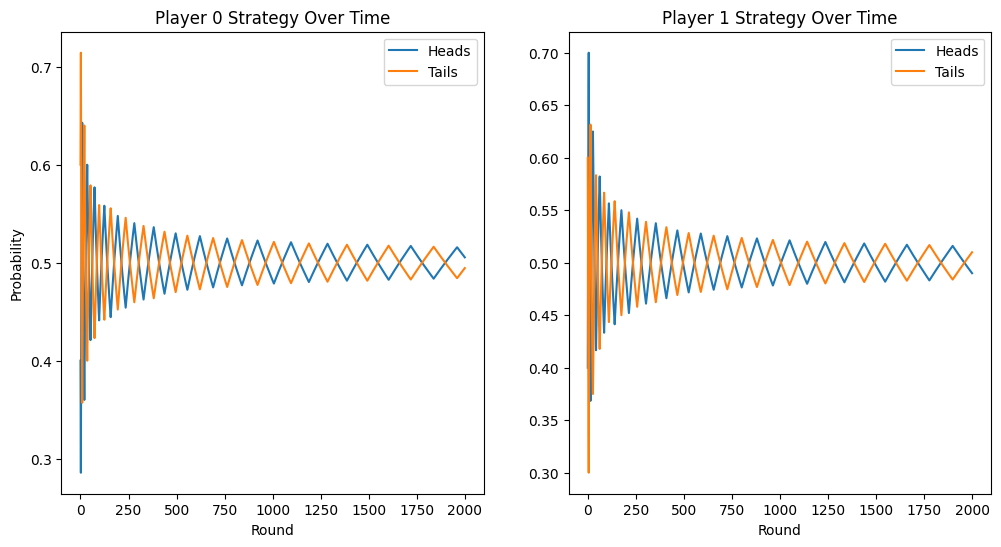

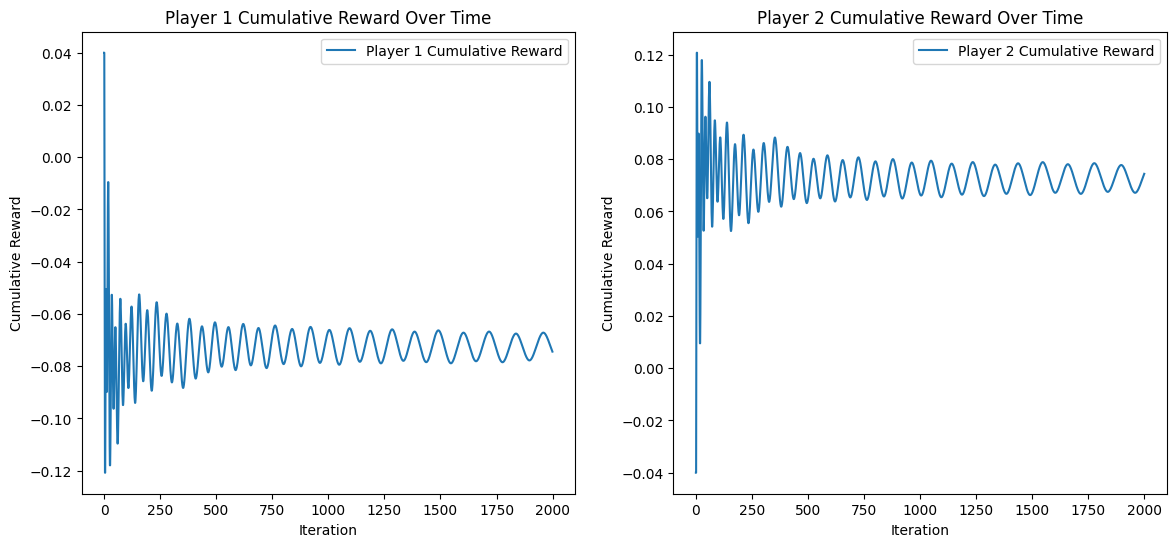

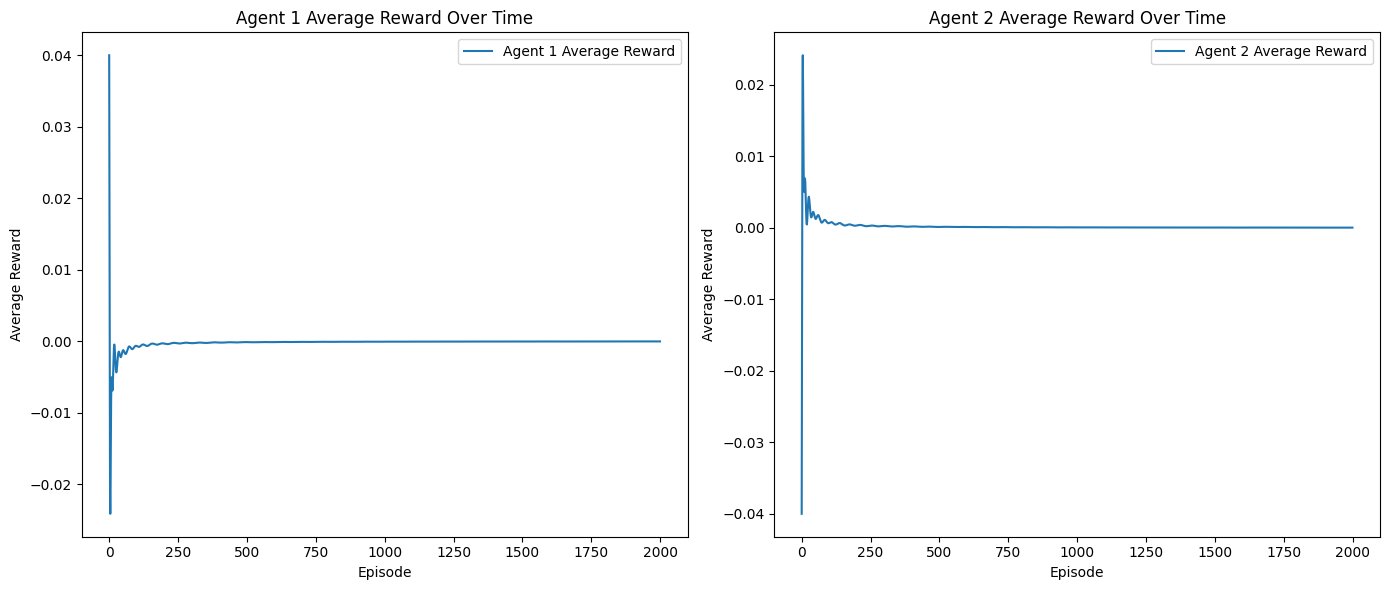

In [3]:
# Required Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

# Strategy Trainer Class
class StrategyTrainer:
  def __init__(self, num_iterations, strategy_self, strategy_opponent, strategy_payoff):
    self.num_iterations = num_iterations
    self.strategy_self = strategy_self
    self.strategy_opponent = strategy_opponent
    self.strategy_payoff = strategy_payoff

  def compute_strategy_from_utility(self, utility_action_0, utility_action_1):
    computed_strategy = np.array([0, 0])

    if utility_action_0 > utility_action_1:
      computed_strategy[0] = 1
    else:
      computed_strategy[1] = 1
    return computed_strategy

  def compute_best_response_self(self, opponent_strategy):
    utility_action_0 = opponent_strategy[0]*self.strategy_payoff[0][0] + opponent_strategy[1]*self.strategy_payoff[1][0]
    utility_action_1 = opponent_strategy[0]*self.strategy_payoff[2][0] + opponent_strategy[1]*self.strategy_payoff[3][0]
    return self.compute_strategy_from_utility(utility_action_0, utility_action_1)

  def compute_best_response_opponent(self, self_strategy):
    utility_action_0 = self_strategy[0]*self.strategy_payoff[0][1] + self_strategy[1]*self.strategy_payoff[2][1]
    utility_action_1 = self_strategy[0]*self.strategy_payoff[1][1] + self_strategy[1]*self.strategy_payoff[3][1]
    return self.compute_strategy_from_utility(utility_action_0, utility_action_1)

  def calculate_utility(self, strategy_self, strategy_opponent):
    # Calculate the utility for self and opponent
    utility_self = strategy_self[0] * (strategy_opponent[0] * self.strategy_payoff[0][0] + strategy_opponent[1] * self.strategy_payoff[1][0]) + strategy_self[1] * (strategy_opponent[0] * self.strategy_payoff[2][0] + strategy_opponent[1] * self.strategy_payoff[3][0])
    utility_opponent = strategy_opponent[0] * (strategy_self[0] * self.strategy_payoff[0][1] + strategy_self[1] * self.strategy_payoff[2][1]) + strategy_opponent[1] * (strategy_self[0] * self.strategy_payoff[1][1] + strategy_self[1] * self.strategy_payoff[3][1])
    return utility_self, utility_opponent

  def train_strategies(self):
    strategy_self_history = []
    strategy_opponent_history = []
    reward_self_history = []
    reward_opponent_history = []
    total_reward_self = 0
    total_reward_opponent = 0
    cum1 = []
    cum2 = []

    for iteration in range(self.num_iterations):
      learning_rate = 1 / (iteration + 5)

      best_response_self = self.compute_best_response_self(self.strategy_opponent)
      best_response_opponent = self.compute_best_response_opponent(self.strategy_self)

      self.strategy_self = (1-learning_rate)*self.strategy_self + learning_rate*best_response_self
      self.strategy_opponent = (1-learning_rate)*self.strategy_opponent + learning_rate*best_response_opponent

      strategy_self_history.append(self.strategy_self.copy())
      strategy_opponent_history.append(self.strategy_opponent.copy())

      # Calculate rewards based on the updated strategies
      utility_self, utility_opponent = self.calculate_utility(self.strategy_self, self.strategy_opponent)
      total_reward_self += utility_self
      total_reward_opponent += utility_opponent

      cum1.append(total_reward_self)
      cum2.append(total_reward_opponent)

      reward_self_history.append(total_reward_self/ (iteration + 1))
      reward_opponent_history.append(total_reward_opponent/ (iteration + 1))

    return self.strategy_self, self.strategy_opponent, strategy_self_history, strategy_opponent_history, reward_self_history, reward_opponent_history, cum1, cum2

# Initial Configuration
initial_strategy_self = np.array([0.5, 0.5], dtype="float")
initial_strategy_opponent = np.array([0.5, 0.5], dtype="float")
# initial_strategy_self= np.array([0.1, 0.9], dtype = "float")
# initial_strategy_opponent= np.array([0.6, 0.4], dtype = "float")
total_iterations = 2000
game_payoff = [[1,-1], [-1, 1], [-1,1], [1, -1]]

# Training
strategy_trainer = StrategyTrainer(num_iterations=total_iterations, strategy_self=initial_strategy_self, strategy_opponent=initial_strategy_opponent, strategy_payoff=game_payoff)
training_results = strategy_trainer.train_strategies()
print("Self strategy:", training_results[0], "Opponent strategy:", training_results[1])

# Processing and Plotting Strategy Evolution
self_strategy_evolution = np.array(training_results[2])
opponent_strategy_evolution = np.array(training_results[3])

# Further analysis and plotting code can remain the same as it operates on the results of the training process.
print("player0 strategy:", training_results[0], "player1 strategy:", training_results[1])

# Calculate average rewards over time
average_me_rewards = training_results[4]
average_opp_rewards = training_results[5]

# Calculate cumulative rewards over time
cumulative_me_rewards = training_results[6]
cumulative_opp_rewards = training_results[7]


plt.figure(figsize=(12, 6))

# Plotting player 0's strategy
plt.subplot(1, 2, 1)
plt.plot(training_results[2], label=['Heads', 'Tails'])
plt.title('Player 0 Strategy Over Time')
plt.xlabel('Round')
plt.ylabel('Probability')
plt.legend()

# Plotting player 1's strategy
plt.subplot(1, 2, 2)
plt.plot(training_results[3], label=['Heads', 'Tails'])
plt.title('Player 1 Strategy Over Time')
plt.xlabel('Round')
plt.legend()

# Plot cumulative rewards over time for each player
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_me_rewards, label='Player 1 Cumulative Reward')
plt.title('Player 1 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_opp_rewards, label='Player 2 Cumulative Reward')
plt.title('Player 2 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

# Plot average rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(average_me_rewards, label='Agent 1 Average Reward')
plt.title('Agent 1 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(average_opp_rewards, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.tight_layout()
plt.show()


# FP VS FP Selling damaged Goods

Self strategy: [0.99800797 0.00199203] Opponent strategy: [0.00199203 0.99800797]
player0 strategy: [0.99800797 0.00199203] player1 strategy: [0.00199203 0.99800797]


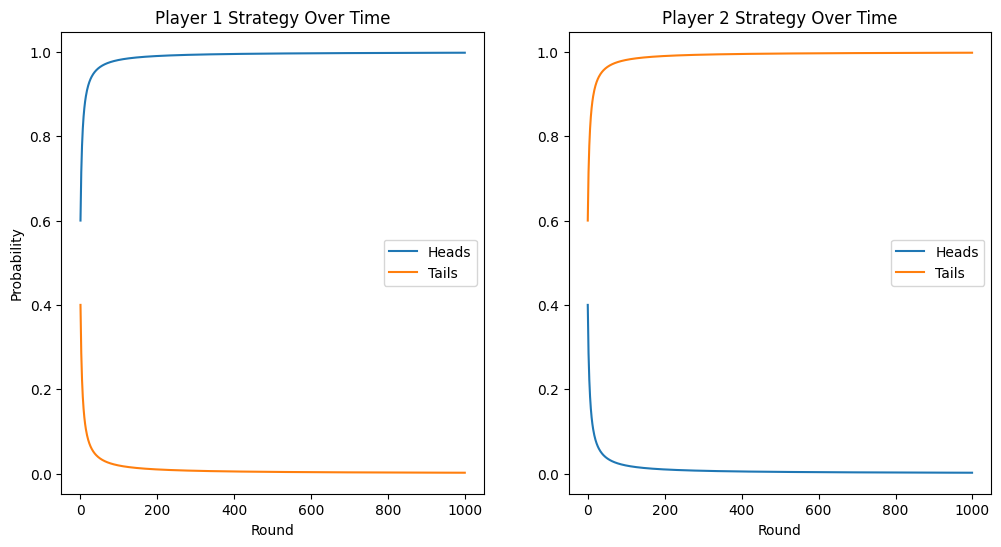

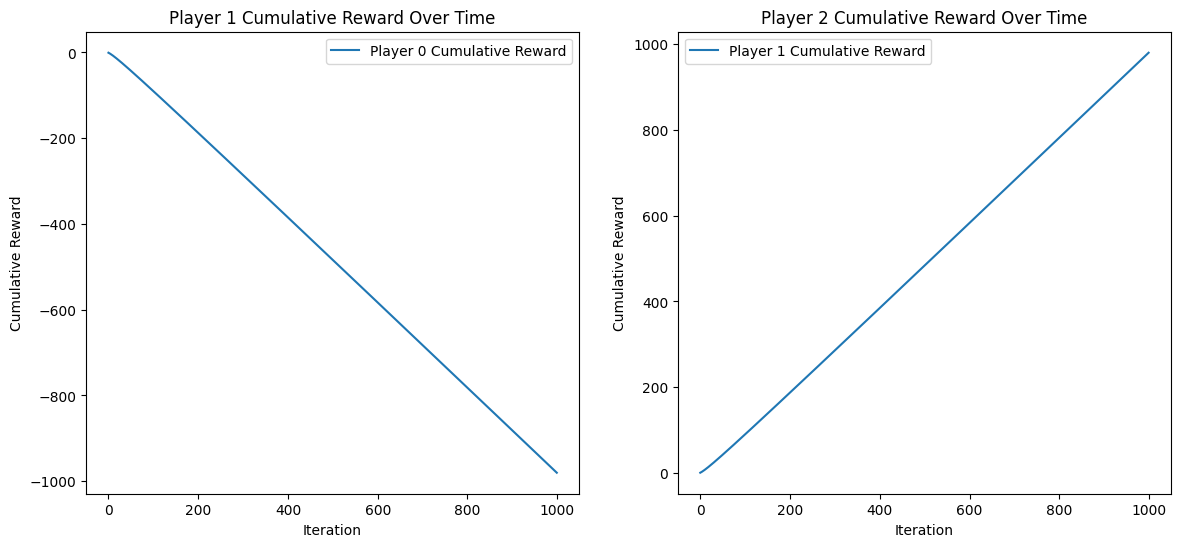

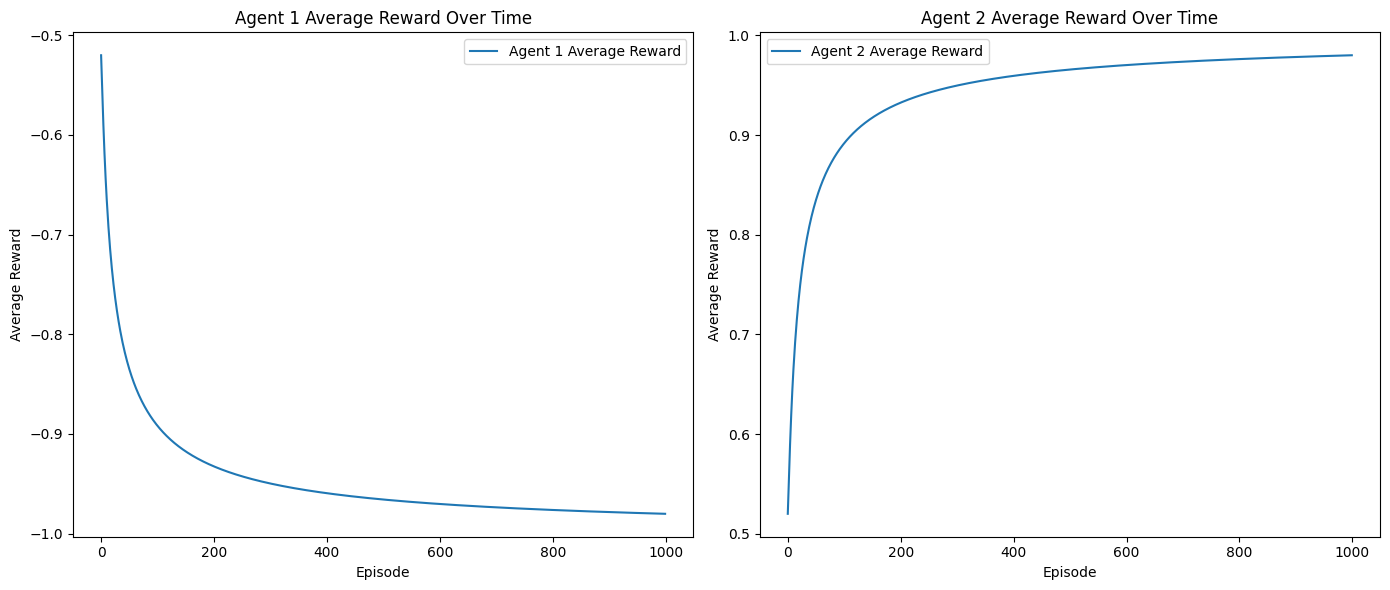

In [4]:

#config1
initial_strategy_self = np.array([0.5, 0.5], dtype = "float")
initial_strategy_opponent = np.array([0.5, 0.5], dtype = "float")
total_iterations = 1000
game_payoff =  [[1, -1], [-1, 1],[-1, 1], [-1, 1]]

# Training
strategy_trainer = StrategyTrainer(num_iterations=total_iterations, strategy_self=initial_strategy_self, strategy_opponent=initial_strategy_opponent, strategy_payoff=game_payoff)
training_results = strategy_trainer.train_strategies()
print("Self strategy:", training_results[0], "Opponent strategy:", training_results[1])

# Processing and Plotting Strategy Evolution
self_strategy_evolution = np.array(training_results[2])
opponent_strategy_evolution = np.array(training_results[3])

# Further analysis and plotting code can remain the same as it operates on the results of the training process.
print("player0 strategy:", training_results[0], "player1 strategy:", training_results[1])

# Calculate average rewards over time
average_me_rewards = training_results[4]
average_opp_rewards = training_results[5]

# Calculate cumulative rewards over time
cumulative_me_rewards =  training_results[6]#np.cumsum(average_me_rewards)
cumulative_opp_rewards =  training_results[7]#np.cumsum(average_opp_rewards)


plt.figure(figsize=(12, 6))

# Plotting player 0's strategy
plt.subplot(1, 2, 1)
plt.plot(training_results[2], label=['Heads', 'Tails'])
plt.title('Player 1 Strategy Over Time')
plt.xlabel('Round')
plt.ylabel('Probability')
plt.legend()

# Plotting player 1's strategy
plt.subplot(1, 2, 2)
plt.plot(training_results[3], label=['Heads', 'Tails'])
plt.title('Player 2 Strategy Over Time')
plt.xlabel('Round')
plt.legend()

# Plot cumulative rewards over time for each player
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_me_rewards, label='Player 0 Cumulative Reward')
plt.title('Player 1 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_opp_rewards, label='Player 1 Cumulative Reward')
plt.title('Player 2 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

# Plot average rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(average_me_rewards, label='Agent 1 Average Reward')
plt.title('Agent 1 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(average_opp_rewards, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.tight_layout()
plt.show()


# Fictitious Agent vs Fictitious Agent [ 3 action game ]

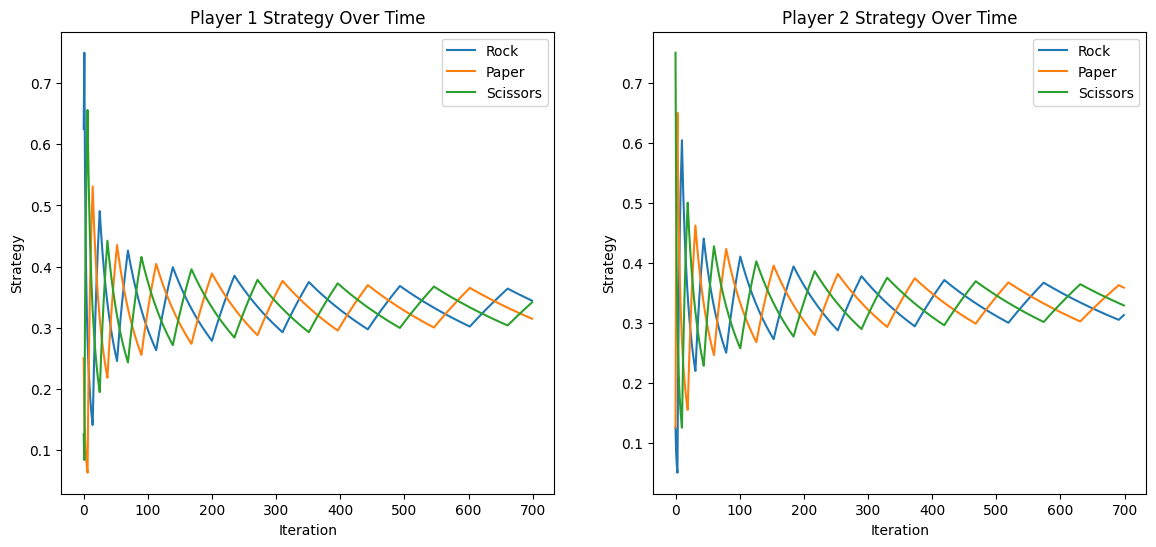

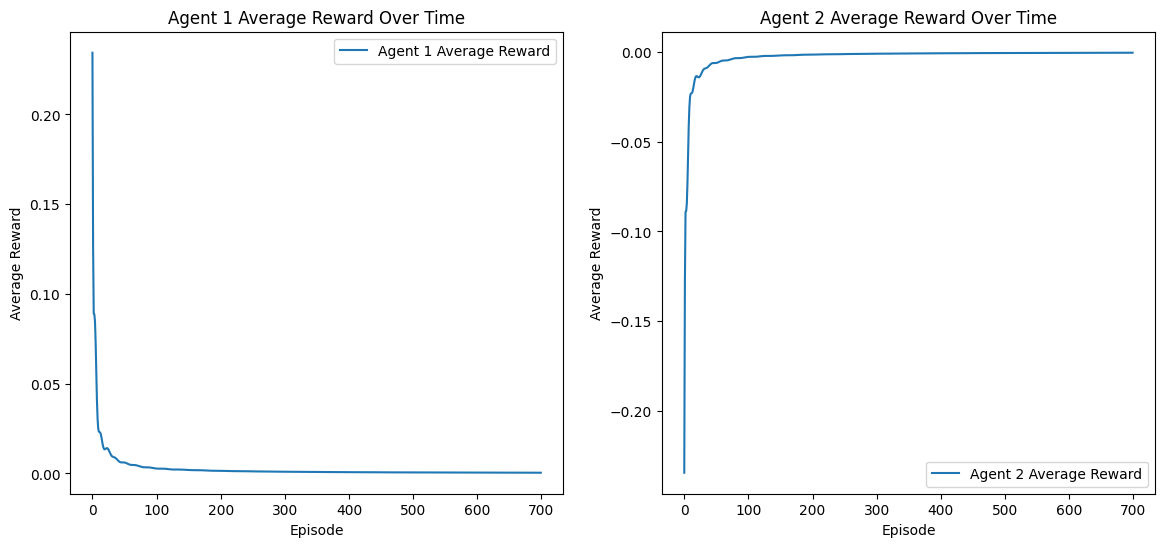

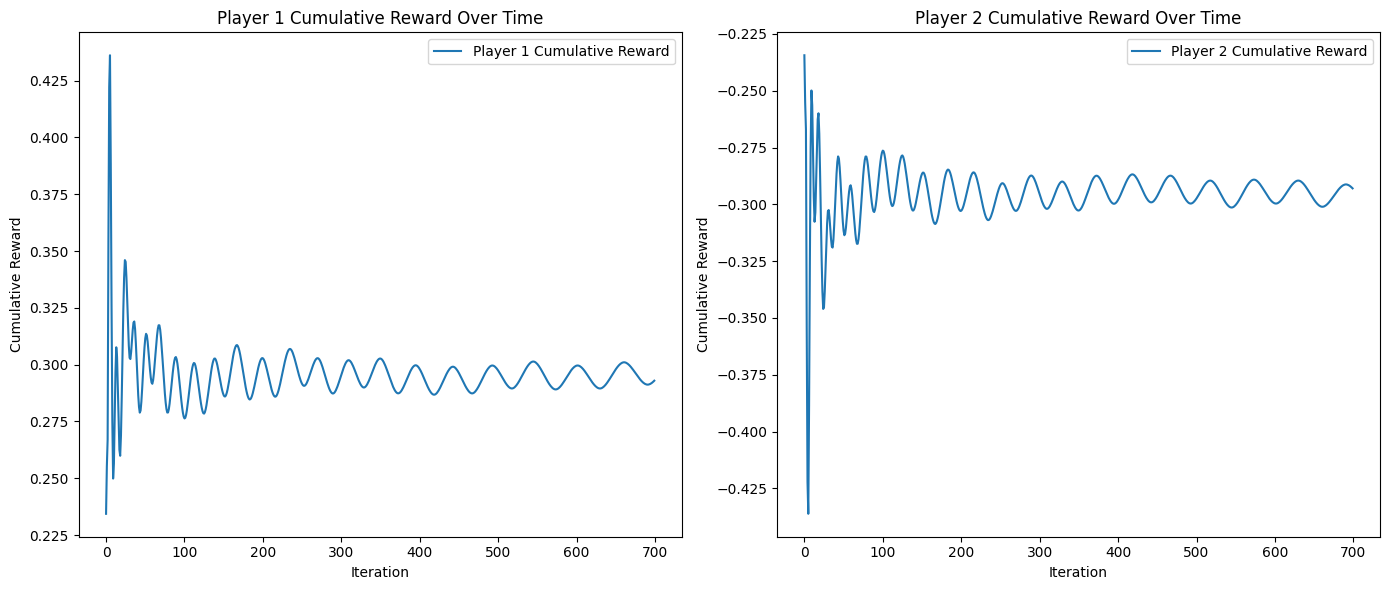

In [5]:

import numpy as np
import matplotlib.pyplot as plt

class StrategyTrainer:
    def __init__(self, total_rounds, player_strategy_avg, opponent_strategy_avg, game_payoff_matrix):
        self.total_rounds = total_rounds
        self.player_strategy_avg = player_strategy_avg
        self.opponent_strategy_avg = opponent_strategy_avg
        self.game_payoff_matrix = game_payoff_matrix

    def find_optimal_response(self, strategy_other):
        expected_utilities = np.dot(self.game_payoff_matrix, strategy_other)
        optimal_response_index = np.argmax(expected_utilities)
        optimal_strategy = np.zeros_like(expected_utilities)
        optimal_strategy[optimal_response_index] = 1.0
        return optimal_strategy

    def calculate_utility2(self,strategy_self, strategy_opponent):

        reward_matrix = [[[0,0], [-1,1], [1,-1]],
                    [[1,-1], [0,0], [-1,1]],
                    [[-1,1], [1,-1], [0,0]]]

        # Calculate the utility for self and opponent
        utility_self = strategy_self[0] * (strategy_opponent[0] * reward_matrix[0][0][0] + strategy_opponent[1] * reward_matrix[0][1][0]+ strategy_opponent[2] * reward_matrix[0][2][0]) +\
        + strategy_self[1] * (strategy_opponent[0] * reward_matrix[1][0][0] + strategy_opponent[1] * reward_matrix[1][1][0]+ strategy_opponent[2] * reward_matrix[1][2][0])+\
        + strategy_self[2] * (strategy_opponent[0] * reward_matrix[2][0][0] + strategy_opponent[1] * reward_matrix[2][1][0]+ strategy_opponent[2] * reward_matrix[2][2][0])

        utility_opponent = strategy_opponent[0] * (strategy_self[0] * reward_matrix[0][0][1] + strategy_self[1] * reward_matrix[1][0][1]+ strategy_self[2] * reward_matrix[2][0][1]) +\
        + strategy_opponent[1] * (strategy_self[0] * reward_matrix[0][1][1] + strategy_self[1] * reward_matrix[1][1][1]+ strategy_self[2] * reward_matrix[2][1][1])+\
        + strategy_opponent[2] * (strategy_self[0] * reward_matrix[0][2][1] + strategy_self[1] * reward_matrix[1][2][1]+ strategy_self[2] * reward_matrix[2][2][1])
        return utility_self, utility_opponent

    # def calculate_utility2(self, strategy_self, strategy_opponent):
    #     # Assuming self's payoffs are in the rows of game_payoff_matrix
    #     utility_self = np.dot(strategy_self, np.dot(self.game_payoff_matrix, strategy_opponent))
    #     # The opponent's utility is the negative of self's utility because it's a zero-sum game
    #     utility_opponent = -utility_self
    #     return utility_self, utility_opponent


    def optimize_strategy(self):
        strategies_player = []
        strategies_opponent = []
        rewards_player = []
        rewards_opponent = []
        cumulative_player = []
        cumulative_opponent = []
        cumulative_reward_agent1=0
        cumulative_reward_agent2=0

        for round_num in range(self.total_rounds):
            learning_rate = 1 / (round_num + 2)

            optimal_player_response = self.find_optimal_response(self.opponent_strategy_avg)
            optimal_opponent_response = self.find_optimal_response(self.player_strategy_avg)

            self.player_strategy_avg = (1 - learning_rate) * self.player_strategy_avg + learning_rate * optimal_player_response
            self.opponent_strategy_avg = (1 - learning_rate) * self.opponent_strategy_avg + learning_rate * optimal_opponent_response

            strategies_player.append(self.player_strategy_avg.copy())
            strategies_opponent.append(self.opponent_strategy_avg.copy())

            reward_player,reward_opponent = self.calculate_utility2(self.player_strategy_avg,self.opponent_strategy_avg)

            # Update cumulative rewards
            cumulative_reward_agent1 += reward_player
            cumulative_reward_agent2 += reward_opponent

            # Store history for plotting
            cumulative_player.append(cumulative_reward_agent1)
            cumulative_opponent.append(cumulative_reward_agent2)

            rewards_player .append(cumulative_reward_agent1 / (round_num + 1))
            rewards_opponent.append(cumulative_reward_agent2 / (round_num + 1))


        return self.player_strategy_avg, self.opponent_strategy_avg, strategies_player, strategies_opponent, rewards_player, rewards_opponent, cumulative_player, cumulative_opponent

# Example usage
game_payoff_matrix = np.array([
    [0, -1, 1],  # Rock: loses to Paper (-1), beats Scissors (1)
    [1, 0, -1],  # Paper: beats Rock (1), loses to Scissors (-1)
    [-1, 1, 0]   # Scissors: loses to Rock (-1), beats Paper (1)
])

total_rounds = 700
player_strategy_avg = np.array([1/4, 2/4, 1/4], dtype="float")
opponent_strategy_avg = np.array([1/4, 1/4, 2/4], dtype="float")

trainer = StrategyTrainer(total_rounds, player_strategy_avg, opponent_strategy_avg, game_payoff_matrix)
player_strategy_avg, opponent_strategy_avg, strategies_player, strategies_opponent, rewards_player, rewards_opponent, cumulative_player_rewards, cumulative_opponent_rewards  = trainer.optimize_strategy()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

# Plotting strategies over time (implementation depends on the data structure of lists)
# Example plot for player 0's strategy over time
plt.plot(strategies_player)
plt.title('Player 1 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Rock', 'Paper', 'Scissors'])


plt.subplot(1, 2, 2)
# Plotting strategies over time (implementation depends on the data structure of lists)
# Example plot for player 0's strategy over time
plt.plot(strategies_opponent)
plt.title('Player 2 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Rock', 'Paper', 'Scissors'])

# Plot average rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_player, label='Agent 1 Average Reward')
plt.title('Agent 1 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rewards_opponent, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

# Plot cumulative rewards over time for each player
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_player_rewards, label='Player 1 Cumulative Reward')
plt.title('Player 1 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_opponent_rewards, label='Player 2 Cumulative Reward')
plt.title('Player 2 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.tight_layout()
plt.show()


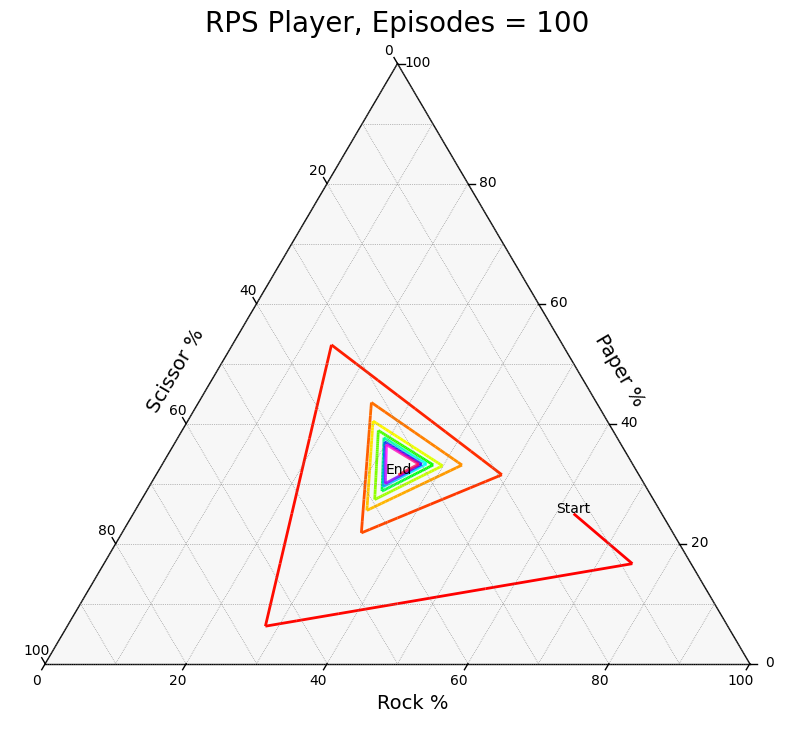

In [6]:
plot_ternary_diagram(strategies_player)

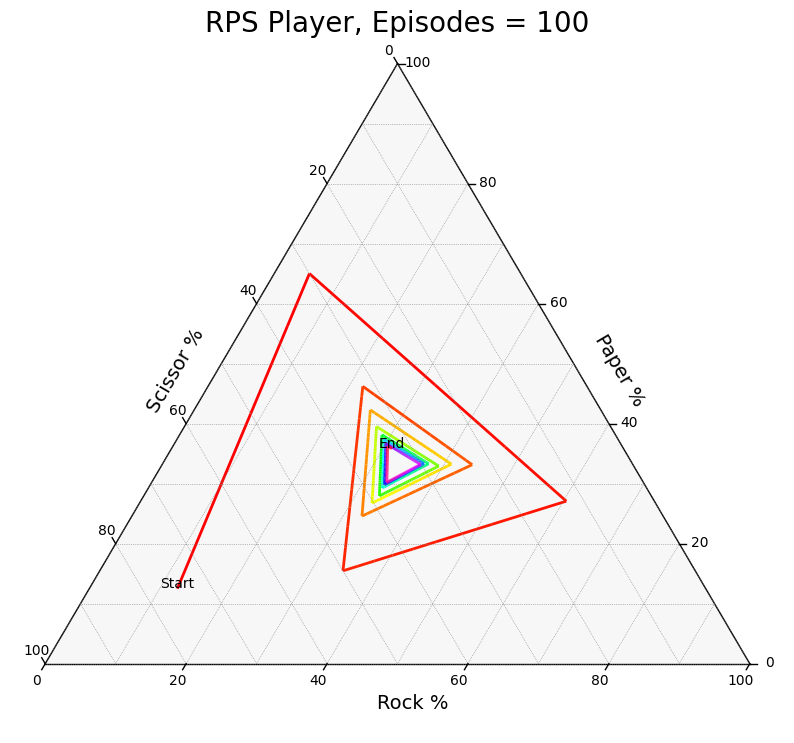

In [7]:
plot_ternary_diagram(strategies_opponent)

# RL vs RL 3 [action game]

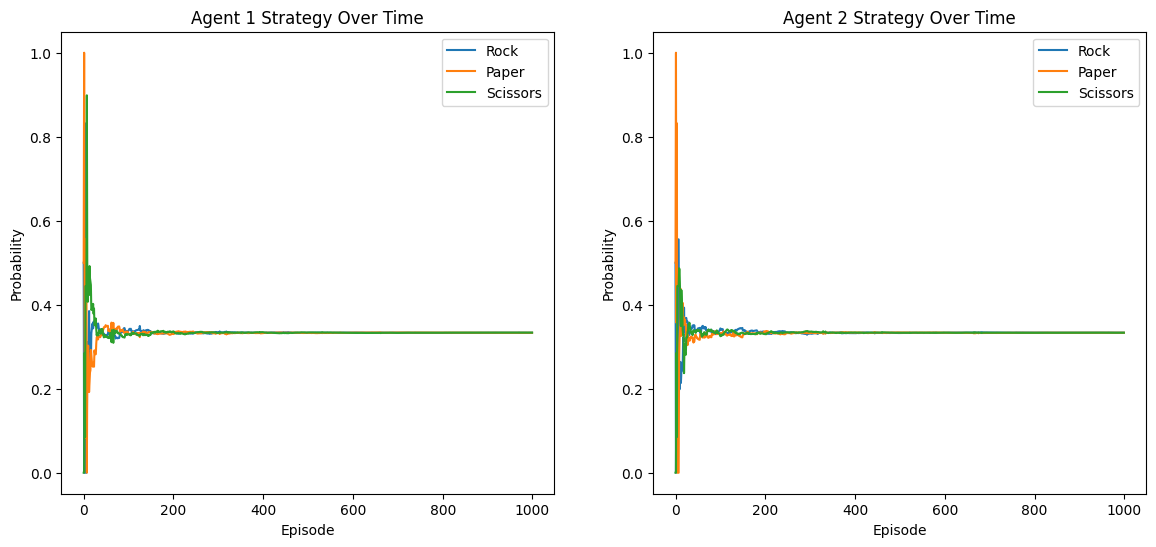

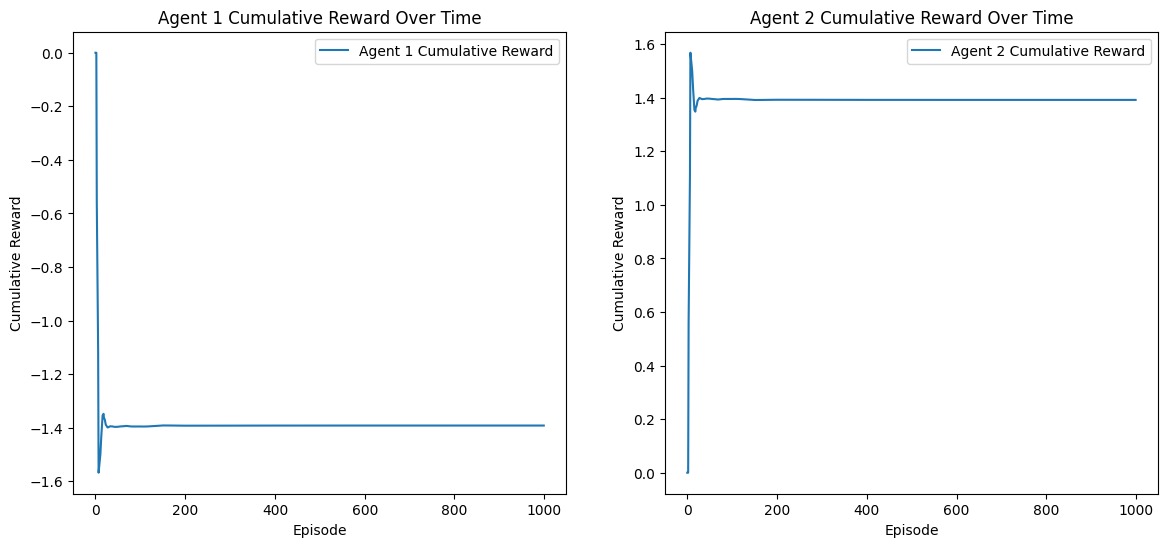

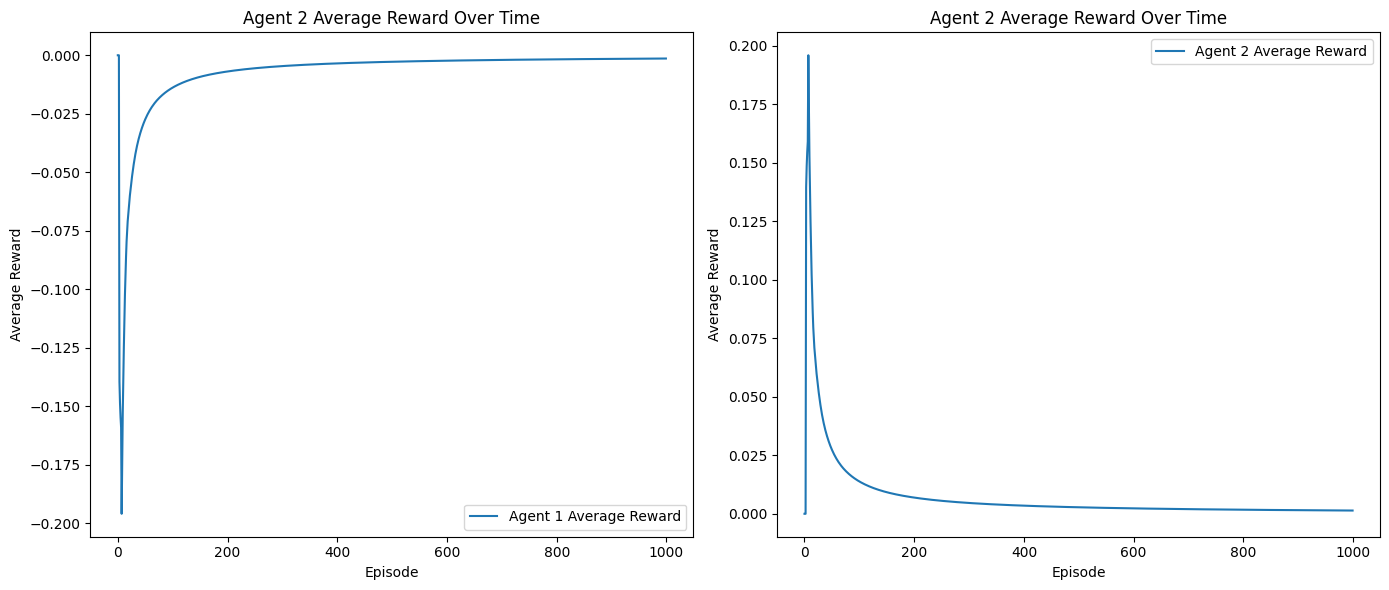

In [8]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Define the payoff matrix for Rock, Paper, Scissors
payoffs = np.array([

    [[ 0,-1, 1],
    [ 1, 0,-1],
    [-1, 1, 0]],  # Player 1's perspective

    [[ 0,1, -1],
    [ -1, 0,1],
    [1, -1, 0]],   # Player 2's perspective (opposite)

])

reward_matrix = [[[0,0], [-1,1], [1,-1]],
                 [[1,-1], [0,0], [-1,1]],
                 [[-1,1], [1,-1], [0,0]]]

class QAgent:
    def __init__(self, explor, learning_rate, gamma, player_id):

        self.explor = explor
        self.learning_rate = learning_rate
        self.P = [1.0 / len([0,1,2])] * len([0,1,2])  # Initial probability distribution
        self.Q = np.ones((3, 3))  # Initialize Q-values
        self.V = 1.0  # Initial value function
        self.gamma = gamma  # Discount factor
        self.payoffs = payoffs[player_id - 1]  # Payoff matrix
        self.player_id = player_id  # Player ID (1 or 2)

    def take_action(self):
        if random.uniform(0, 1) < self.explor:
            return random.choice([0, 1, 2])
        else:
            return random.choices([0, 1, 2], weights=self.P, k=1)[0]

    def observe(self, action, opponent):
        # Get payoff based on action and opponent's action
        return self.payoffs[action][opponent]

    def update_Q(self, action, opponent, reward):

        # Update Q-value for taken action and opponent's action
        self.Q[action, opponent] = (1 - self.learning_rate) * self.Q[action, opponent] + \
                                   self.learning_rate * (reward + self.gamma * self.V)

    def update_P(self):
        # Update strategy P using linear programming to solve for the mixed strategy Nash Equilibrium
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Constraint: probabilities must sum to 1
        bnds = [(0, 1) for _ in range(3)]  # Bounds: probabilities between 0 and 1
        result = minimize(fun=lambda x: -np.min(np.dot(x, self.Q )),
                          x0=np.array([0., 0., 0.]), bounds=bnds, constraints=cons)
        self.P = result.x

    def update_V(self):
        # Update value function V
        self.V = np.min(np.dot(self.P, self.Q )) #np.sum(np.dot(self.P, np.max(self.Q, axis=1)))


def calculate_utility(strategy_self, strategy_opponent):

    # Calculate the utility for self and opponent
    utility_self = strategy_self[0] * (strategy_opponent[0] * reward_matrix[0][0][0] + strategy_opponent[1] * reward_matrix[0][1][0]+ strategy_opponent[2] * reward_matrix[0][2][0]) +\
    + strategy_self[1] * (strategy_opponent[0] * reward_matrix[1][0][0] + strategy_opponent[1] * reward_matrix[1][1][0]+ strategy_opponent[2] * reward_matrix[1][2][0])+\
    + strategy_self[2] * (strategy_opponent[0] * reward_matrix[2][0][0] + strategy_opponent[1] * reward_matrix[2][1][0]+ strategy_opponent[2] * reward_matrix[2][2][0])

    utility_opponent = strategy_opponent[0] * (strategy_self[0] * reward_matrix[0][0][1] + strategy_self[1] * reward_matrix[1][0][1]+ strategy_self[2] * reward_matrix[2][0][1]) +\
    + strategy_opponent[1] * (strategy_self[0] * reward_matrix[0][1][1] + strategy_self[1] * reward_matrix[1][1][1]+ strategy_self[2] * reward_matrix[2][1][1])+\
    + strategy_opponent[2] * (strategy_self[0] * reward_matrix[0][2][1] + strategy_self[1] * reward_matrix[1][2][1]+ strategy_self[2] * reward_matrix[2][2][1])
    return utility_self, utility_opponent


# Run simulation function
def run_simulation(num_episodes=1000, explor=0.3, learning_rate=1.0, gamma=0.9):
    # Initialize agents
    agent1 = QAgent(explor=explor, learning_rate=learning_rate, gamma=gamma, player_id=1)
    agent2 = QAgent(explor=explor, learning_rate=learning_rate, gamma=gamma, player_id=2)

    # History of probabilities for plotting
    prob_history_agent1 = []
    prob_history_agent2 = []

    cumulative_reward_agent1 = 0
    cumulative_reward_agent2 = 0

    cumulative_rewards_history_agent1 = []
    cumulative_rewards_history_agent2 = []

    average_rewards_history_agent1 = []
    average_rewards_history_agent2 = []

    for episode in range(num_episodes):
        action1 = agent1.take_action()
        action2 = agent2.take_action()

        rew1 = agent1.observe(action=action1, opponent=action2)
        rew2 = agent2.observe(action=action2, opponent=action1)

        agent1.update_Q(action=action1, opponent=action2, reward=rew1)
        agent1.update_P()
        agent1.update_V()

        agent2.update_Q(action=action2, opponent=action1, reward=rew2)
        agent2.update_P()
        agent2.update_V()

        u1,u2 = calculate_utility(agent1.P,agent2.P)
        # Update cumulative rewards
        cumulative_reward_agent1 += u1
        cumulative_reward_agent2 += u2

        # Store history for plotting
        cumulative_rewards_history_agent1.append(cumulative_reward_agent1)
        cumulative_rewards_history_agent2.append(cumulative_reward_agent2)

        average_rewards_history_agent1.append(cumulative_reward_agent1 / (episode + 1))
        average_rewards_history_agent2.append(cumulative_reward_agent2 / (episode + 1))

        # Append probabilities to history for plotting
        prob_history_agent1.append(agent1.P.copy())
        prob_history_agent2.append(agent2.P.copy())

        if episode % 75 == 0:
          agent1.learning_rate *= 0.8
          agent2.learning_rate *= 0.8

    # Convert histories to numpy arrays for easy plotting
    prob_history_agent1 = np.array(prob_history_agent1)
    prob_history_agent2 = np.array(prob_history_agent2)

    # Plot the strategies over time for each agent
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(prob_history_agent1[:, 0], label='Rock')
    plt.plot(prob_history_agent1[:, 1], label='Paper')
    plt.plot(prob_history_agent1[:, 2], label='Scissors')
    plt.title('Agent 1 Strategy Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Probability')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(prob_history_agent2[:, 0], label='Rock')
    plt.plot(prob_history_agent2[:, 1], label='Paper')
    plt.plot(prob_history_agent2[:, 2], label='Scissors')
    plt.title('Agent 2 Strategy Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Probability')
    plt.legend()

    # Plot cumulative rewards over time for both agents
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_rewards_history_agent1, label='Agent 1 Cumulative Reward')
    plt.title('Agent 1 Cumulative Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_rewards_history_agent2, label='Agent 2 Cumulative Reward')
    plt.title('Agent 2 Cumulative Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()

    # Plot cumulative rewards over time for both agents
    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    plt.plot(average_rewards_history_agent1, label='Agent 1 Average Reward')
    plt.title('Agent 2 Average Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(average_rewards_history_agent2, label='Agent 2 Average Reward')
    plt.title('Agent 2 Average Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.tight_layout()

    plt.show()

    return prob_history_agent1, prob_history_agent2

agprob1,agprob2= run_simulation(num_episodes=1000)


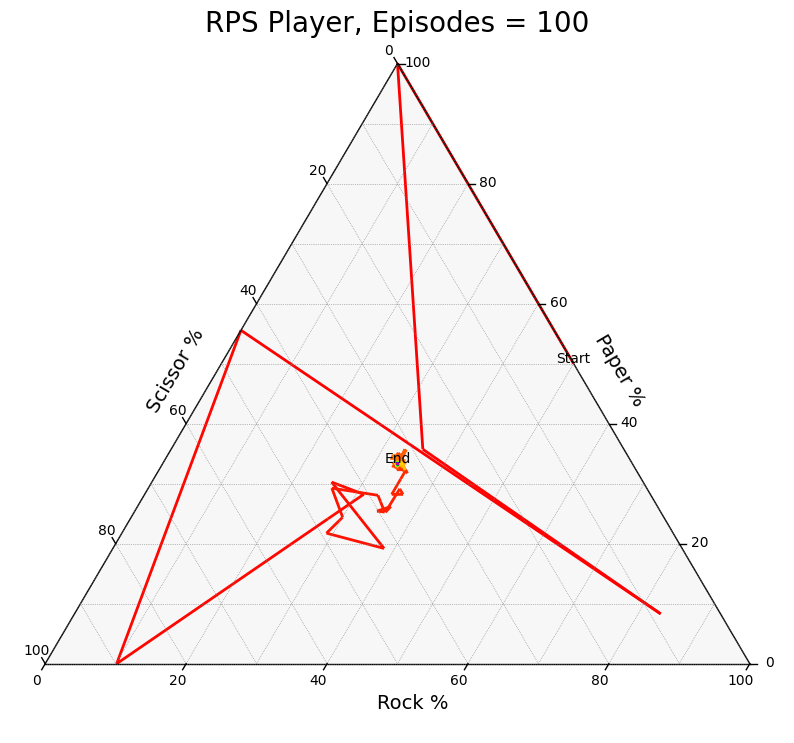

In [9]:
plot_ternary_diagram(agprob1)

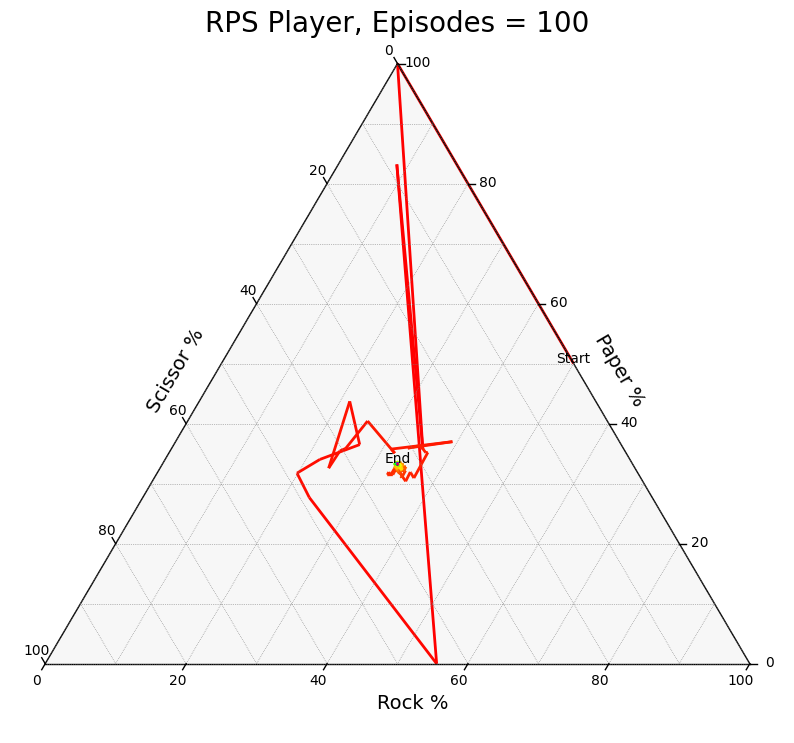

In [10]:
plot_ternary_diagram(agprob2)

# RL vs RL [2 action game]

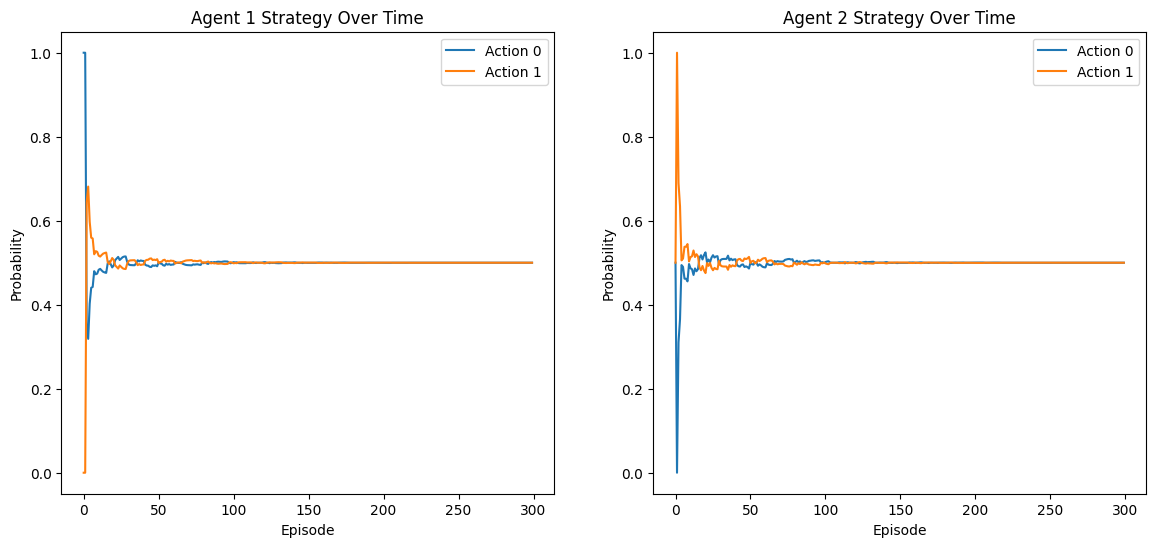

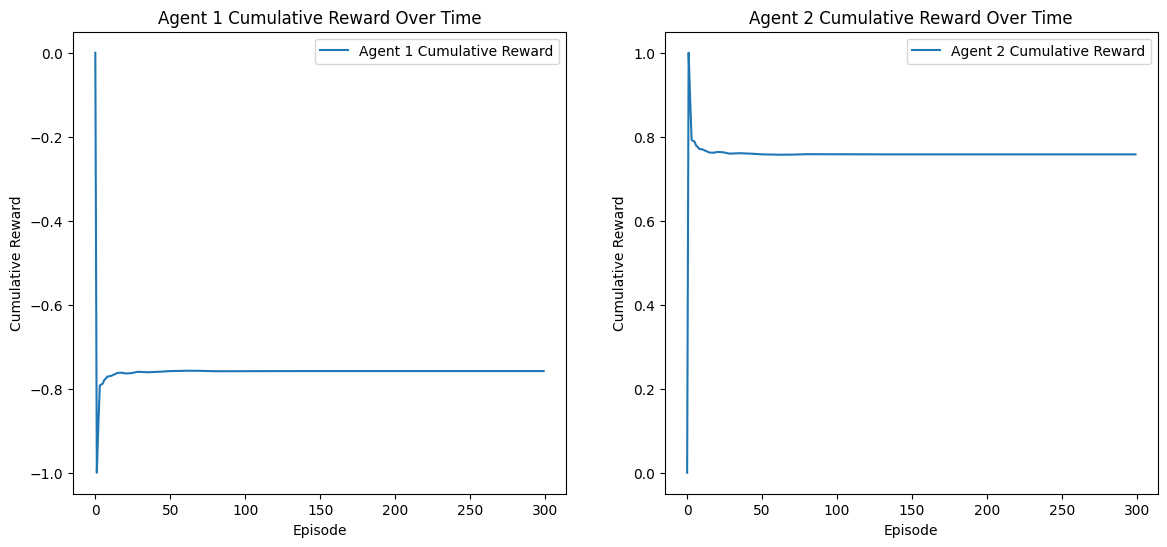

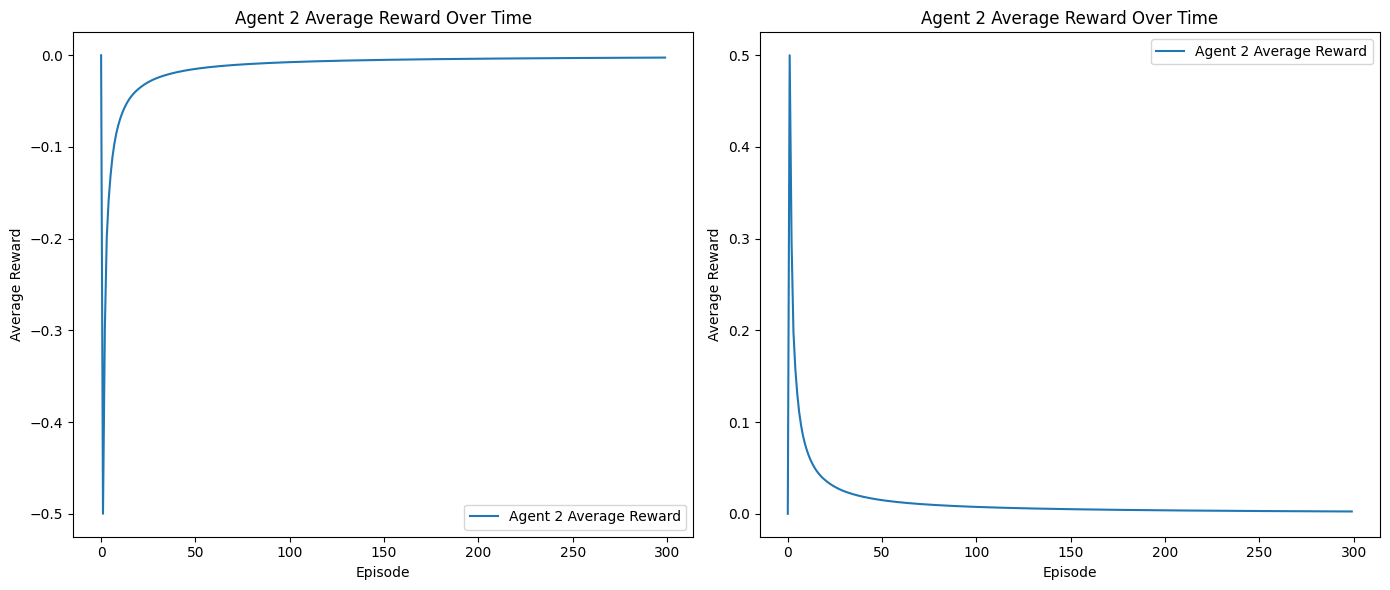

In [11]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# # Define the payoff matrix for a 2-action game

payoffs = np.array([

    [[ 1,-1],
    [ -1, 1]],
  # Player 1's perspective

    [[ -1,1],
    [ 1,-1]],   # Player 2's perspective (opposite)

])

class QAgent:
    def __init__(self, explor, learning_rate, gamma, player_id):
        self.explor = explor
        self.learning_rate = learning_rate
        self.P = [1.0 / 2] * 2  # Adjusted for 2 actions
        self.Q = np.ones((2, 2))  # Adjusted for 2 actions
        self.V = 1.0
        self.gamma = gamma
        self.payoffs = payoffs[player_id - 1]
        self.player_id = player_id

    def take_action(self):
        if random.uniform(0, 1) < self.explor:
            return random.choice([0, 1])
        else:
            return random.choices([0, 1], weights=self.P, k=1)[0]

    def observe(self, action, opponent):
        return self.payoffs[action, opponent]

    def update_Q(self, action, opponent, reward):
        self.Q[action, opponent] = (1 - self.learning_rate) * self.Q[action, opponent] + \
                                   self.learning_rate * (reward + self.gamma * self.V)

    def update_P(self):
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Constraint: probabilities must sum to 1
        bnds = [(0, 1) for _ in range(2)]  # Bounds: probabilities between 0 and 1
        result = minimize(fun=lambda x: -np.min(np.dot(x, self.Q  )),
                          x0=np.array([0., 0.]), bounds=bnds, constraints=cons)
        self.P = result.x

    def update_V(self):
        self.V = np.min(np.dot(self.P,self.Q ))

def calculate_utility(strategy_self, strategy_opponent):
    # Calculate the utility for self and opponent
    utility_self = strategy_self[0] * (strategy_opponent[0] * payoffs[0][0][0] + strategy_opponent[1] * payoffs[0][0][1]) + strategy_self[1] * (strategy_opponent[0] * payoffs[0][1][0] + strategy_opponent[1] * payoffs[0][1][1])
    utility_opponent = strategy_opponent[0] * (strategy_self[0] * payoffs[1][0][0] + strategy_self[1] * payoffs[1][1][0]) + strategy_opponent[1] * (strategy_self[0] * payoffs[1][0][1] + strategy_self[1] * payoffs[1][1][1])
    return utility_self, utility_opponent

def run_simulation(num_episodes=1000, explor=0.3, learning_rate=1.0, gamma=0.9):
    agent1 = QAgent(explor=explor, learning_rate=learning_rate, gamma=gamma, player_id=1)
    agent2 = QAgent(explor=explor, learning_rate=learning_rate, gamma=gamma, player_id=2)

    prob_history_agent1 = []
    prob_history_agent2 = []

    cumulative_reward_agent1 = 0
    cumulative_reward_agent2 = 0

    cumulative_rewards_history_agent1 = []
    cumulative_rewards_history_agent2 = []

    average_rewards_history_agent1 = []
    average_rewards_history_agent2 = []

    for episode in range(num_episodes):
        learning_rate = 1 / (episode + 2)
        action1 = agent1.take_action()
        action2 = agent2.take_action()

        reward1 = agent1.observe(action=action1, opponent=action2)
        reward2 = agent2.observe(action=action2, opponent=action1)

        agent1.update_Q(action=action1, opponent=action2, reward=reward1)
        agent1.update_P()
        agent1.update_V()

        agent2.update_Q(action=action2, opponent=action1, reward=reward2)
        agent2.update_P()
        agent2.update_V()

        u1,u2= calculate_utility(agent1.P,agent2.P)
        # Update cumulative rewards
        cumulative_reward_agent1 += u1#reward1
        cumulative_reward_agent2 += u2#reward2

        # Store history for plotting
        cumulative_rewards_history_agent1.append(cumulative_reward_agent1)
        cumulative_rewards_history_agent2.append(cumulative_reward_agent2)

        average_rewards_history_agent1.append(cumulative_reward_agent1 / (episode + 1))
        average_rewards_history_agent2.append(cumulative_reward_agent2 / (episode + 1))

        prob_history_agent1.append(agent1.P.copy())
        prob_history_agent2.append(agent2.P.copy())

    prob_history_agent1 = np.array(prob_history_agent1)
    prob_history_agent2 = np.array(prob_history_agent2)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(prob_history_agent1[:, 0], label='Action 0')
    plt.plot(prob_history_agent1[:, 1], label='Action 1')
    plt.title('Agent 1 Strategy Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Probability')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(prob_history_agent2[:, 0], label='Action 0')
    plt.plot(prob_history_agent2[:, 1], label='Action 1')
    plt.title('Agent 2 Strategy Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Probability')
    plt.legend()

    # Plot cumulative rewards over time for both agents
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_rewards_history_agent1, label='Agent 1 Cumulative Reward')
    plt.title('Agent 1 Cumulative Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_rewards_history_agent2, label='Agent 2 Cumulative Reward')
    plt.title('Agent 2 Cumulative Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()

    # Plot cumulative rewards over time for both agents
    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    plt.plot(average_rewards_history_agent1, label='Agent 2 Average Reward')
    plt.title('Agent 2 Average Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(average_rewards_history_agent2, label='Agent 2 Average Reward')
    plt.title('Agent 2 Average Reward Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_simulation(num_episodes=300)


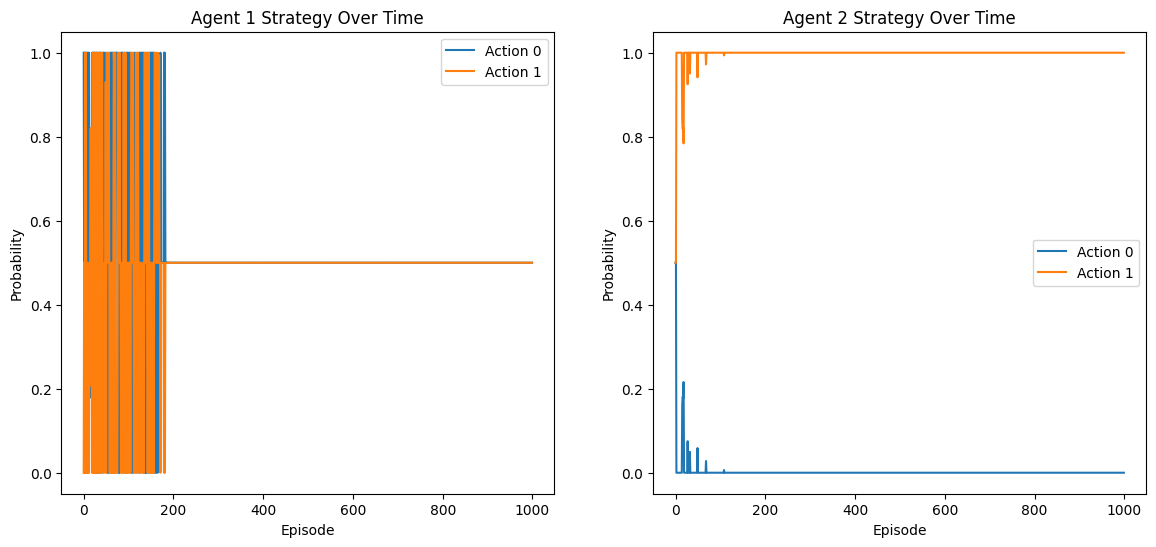

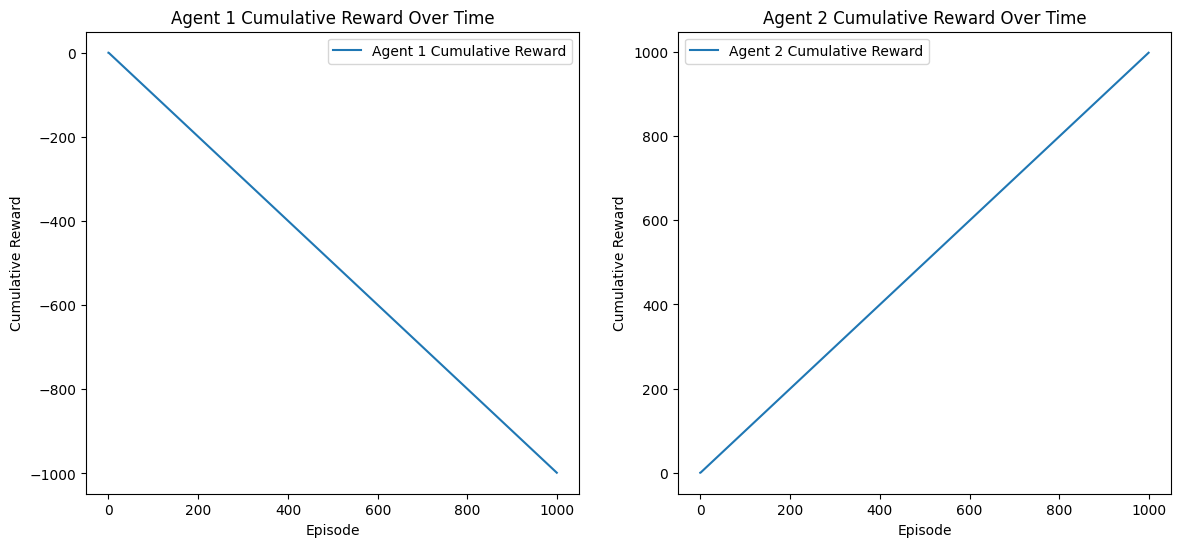

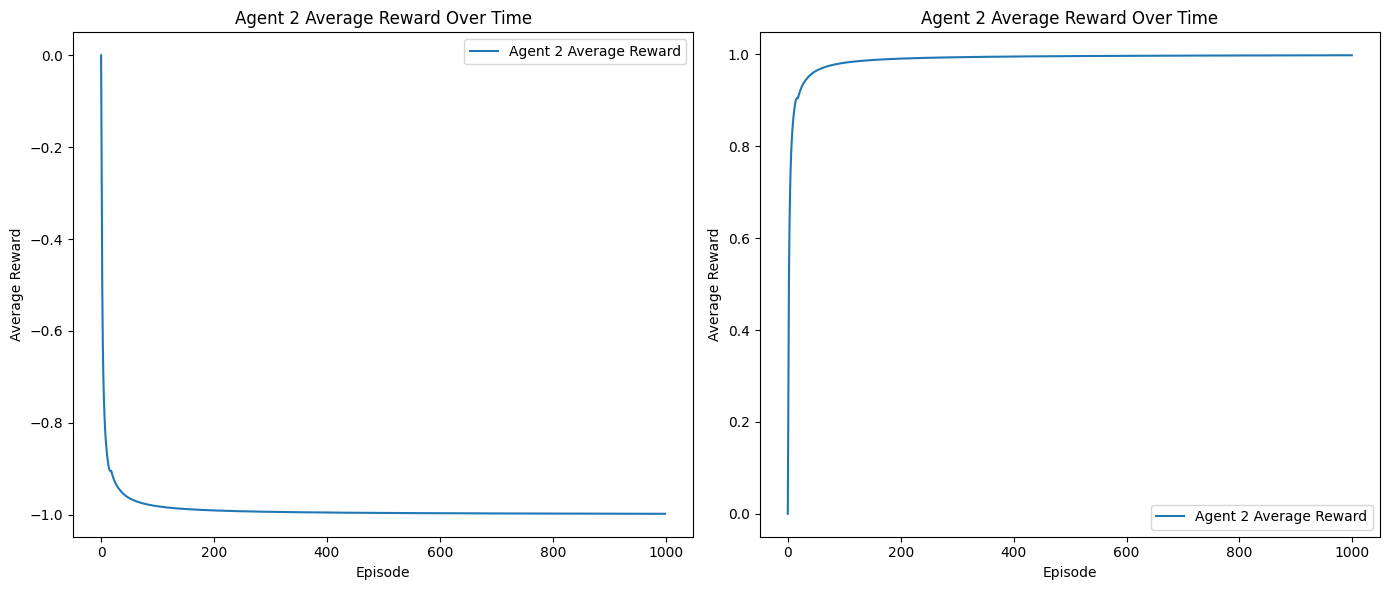

In [12]:

# Define the payoff matrix for Rock, Paper, Scissors
payoffs = np.array([

    [[ 1,-1],
    [ -1, -1]],
  # Player 1's perspective

    [[ -1,1],
    [ 1,1]],   # Player 2's perspective (opposite)

])

if __name__ == '__main__':
    run_simulation(num_episodes=1000)

# FP vs RL

## Rock Paper Scissors

In [13]:
import numpy as np


class FictitiousPlayAgent:
    def __init__(self, actions, payoff_matrix):
        self.actions = actions
        self.payoff_matrix = payoff_matrix
        self.history = []
        self.avg_strategy = np.array([1.0 / len(actions)] * len(actions))

    def update_strategy(self, action, alpha=0.1):
        self.history.append(action)
        mixed_strategy = self.get_mixed_strategy()
        best_response = self.best_response(mixed_strategy)

        # Update the average strategy using alpha
        best_response_strategy = np.zeros(len(self.actions))
        best_response_strategy[best_response] = 1.0
        self.avg_strategy = (1 - alpha) * self.avg_strategy + alpha * best_response_strategy

    def get_mixed_strategy(self):
        if len(self.history) == 0:
            return np.array([1.0 / len(self.actions)] * len(self.actions))
        history = np.array(self.history)
        mixed_strategy = np.mean(np.eye(len(self.actions))[history], axis=0)
        return mixed_strategy

    def best_response(self, mixed_strategy):
        utility = np.dot(self.payoff_matrix, mixed_strategy)
        return np.argmax(utility)

    def act(self):
        # Normalize the average strategy to ensure it sums to 1
        normalized_strategy = self.avg_strategy / np.sum(self.avg_strategy)
        return np.random.choice(self.actions, p=normalized_strategy)

In [14]:


class QAgent:
    def __init__(self, explor, learning_rate, gamma, player_id, actions):
        self.explor = explor
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.player_id = player_id
        self.actions = actions
        self.P = np.full(len(actions), 1.0 / len(actions))
        self.Q = np.zeros((len(actions), len(actions)))
        self.V = 0.0


    def take_action(self):
        if random.uniform(0, 1) < self.explor:
            return random.choice(self.actions)
        else:
            return random.choices(self.actions, weights=self.P, k=1)[0]

    def observe(self, action, opponent, reward):
        self.update_Q(action, opponent, reward)

    def update_Q(self, action, opponent, reward):
        self.Q[action, opponent] = (1 - self.learning_rate) * self.Q[action, opponent] + \
                                   self.learning_rate * (reward + self.gamma * self.V)

    def update_P(self):
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        bnds = [(0, 1) for _ in range(len(self.actions))]
        result = minimize(fun=lambda x: -np.min(np.dot(x, self.Q )),#if self.player_id == 1 else self.Q.T
                          x0=np.array([0.0 / len(self.actions)] *len(self.actions)), bounds=bnds, constraints=cons) #np.array([0.0 / len(self.actions)] *len(self.actions))
        self.P = result.x

    def update_V(self):
        self.V = np.min(np.dot(self.P, self.Q ))


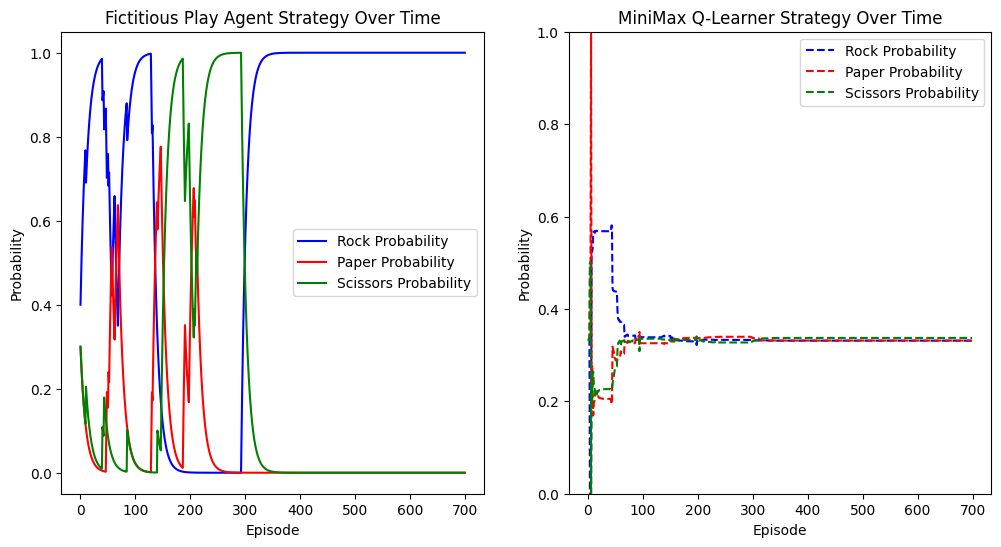

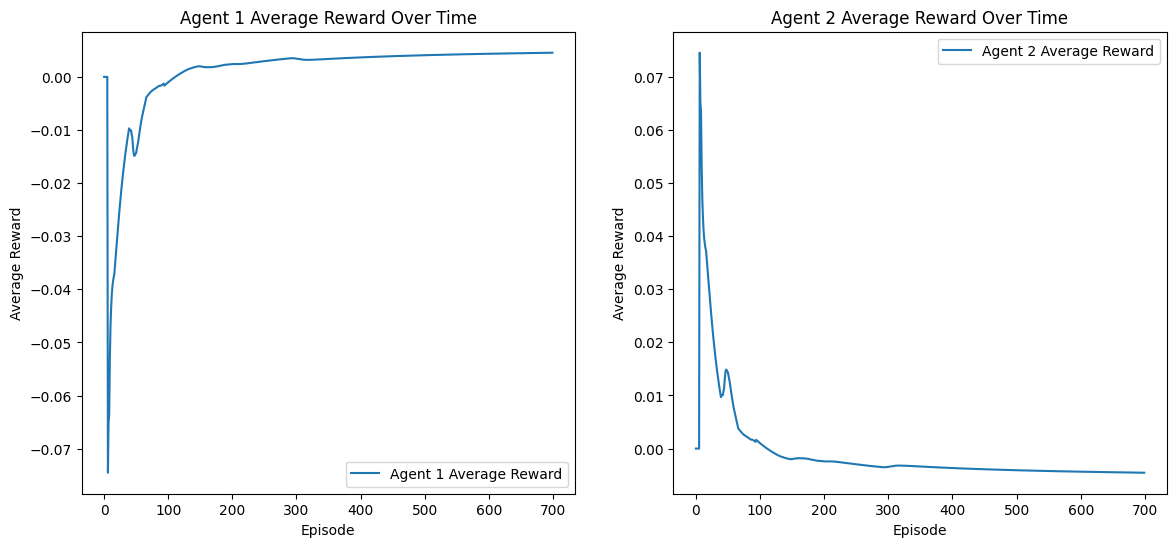

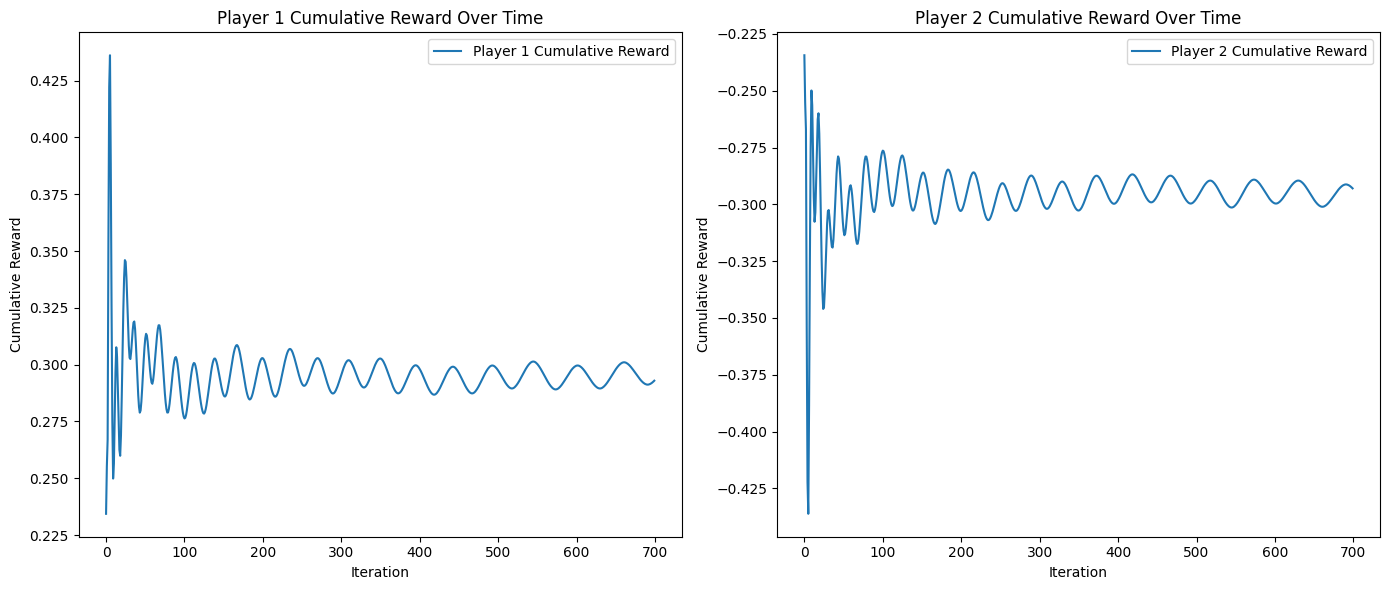

In [15]:
import numpy as np
import matplotlib.pyplot as plt

class MatrixGame:

    def __init__(self):

      self.reward_matrix = np.array(
                 [[[0,0], [-1,1], [1,-1]],
                 [[1,-1], [0,0], [-1,1]],
                 [[-1,1], [1,-1], [0,0]]])

    def step(self, action1, action2):
        return self.reward_matrix[action1][action2]

def calculate_utility(strategy_self, strategy_opponent, payoffs):
        # Calculate the utility for self and opponent
        utility_self = strategy_self[0] * (strategy_opponent[0] * reward_matrix[0][0][0] + strategy_opponent[1] * reward_matrix[0][1][0]+ strategy_opponent[2] * reward_matrix[0][2][0]) +\
        + strategy_self[1] * (strategy_opponent[0] * reward_matrix[1][0][0] + strategy_opponent[1] * reward_matrix[1][1][0]+ strategy_opponent[2] * reward_matrix[1][2][0])+\
        + strategy_self[2] * (strategy_opponent[0] * reward_matrix[2][0][0] + strategy_opponent[1] * reward_matrix[2][1][0]+ strategy_opponent[2] * reward_matrix[2][2][0])

        utility_opponent = strategy_opponent[0] * (strategy_self[0] * reward_matrix[0][0][1] + strategy_self[1] * reward_matrix[1][0][1]+ strategy_self[2] * reward_matrix[2][0][1]) +\
        + strategy_opponent[1] * (strategy_self[0] * reward_matrix[0][1][1] + strategy_self[1] * reward_matrix[1][1][1]+ strategy_self[2] * reward_matrix[2][1][1])+\
        + strategy_opponent[2] * (strategy_self[0] * reward_matrix[0][2][1] + strategy_self[1] * reward_matrix[1][2][1]+ strategy_self[2] * reward_matrix[2][2][1])
        return utility_self, utility_opponent

def run_simulation(episodes, fp_agent, rl_agent, game):
    fp_strategy = []
    rl_strategy = []
    rewards_player = []
    rewards_opponent = []
    cumulative_player = []
    cumulative_opponent = []
    cumulative_reward_agent1=0
    cumulative_reward_agent2=0

    for episode in range(episodes):
        fp_action = fp_agent.act()
        rl_action = rl_agent.take_action()

        reward_fp, reward_rl = game.step(fp_action, rl_action)

        rl_agent.observe(action=rl_action, opponent=fp_action, reward=reward_rl)
        rl_agent.update_Q(rl_action, fp_action, reward_rl)
        rl_agent.update_P()
        rl_agent.update_V()

        fp_agent.update_strategy(rl_action)

        fp_strategy.append(fp_agent.avg_strategy)
        rl_strategy.append(rl_agent.P)

        reward_player,reward_opponent = calculate_utility(fp_agent.avg_strategy,rl_agent.P,game.reward_matrix)

        # Update cumulative rewards
        cumulative_reward_agent1 += reward_player
        cumulative_reward_agent2 += reward_opponent

        # Store history for plotting
        cumulative_player.append(cumulative_reward_agent1)
        cumulative_opponent.append(cumulative_reward_agent2)

        rewards_player.append(cumulative_reward_agent1 / (episode + 1))
        rewards_opponent.append(cumulative_reward_agent2 / (episode + 1))

    return fp_strategy, rl_strategy, rewards_player, rewards_opponent, cumulative_player, cumulative_opponent


# Example Setup
actions = [0, 1, 2]
game = MatrixGame()
fp_agent = FictitiousPlayAgent(actions, game.reward_matrix[:, :, 0])
rl_agent = QAgent(explor=0.1, learning_rate=0.5, gamma=0.9, player_id=2, actions=actions)

fp_strategy, rl_strategy,rewards_player, rewards_opponent, cumulative_player, cumulative_opponent  = run_simulation(episodes=700, fp_agent=fp_agent, rl_agent=rl_agent, game=game)


plt.figure(figsize=(12, 6))

# Plot for Fictitious Play Agent
plt.subplot(1, 2, 1)
plt.plot([s[0] for s in fp_strategy], label='Rock Probability', linestyle='-', color='blue')
plt.plot([s[1] for s in fp_strategy], label='Paper Probability', linestyle='-', color='red')
plt.plot([1 - s[0] - s[1] for s in fp_strategy], label='Scissors Probability', linestyle='-', color='green')
plt.title('Fictitious Play Agent Strategy Over Time')
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.legend()

# Plot for MiniMax Q-Learner
plt.subplot(1, 2, 2)
plt.plot([p[0] for p in rl_strategy], label='Rock Probability', linestyle='--', color='blue')
plt.plot([p[1] for p in rl_strategy], label='Paper Probability', linestyle='--', color='red')
# Since the probabilities must sum to 1, the probability of choosing Scissors can be derived.
plt.plot([1 - p[0] - p[1] for p in rl_strategy], label='Scissors Probability', linestyle='--', color='green')
plt.title('MiniMax Q-Learner Strategy Over Time')
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.legend()
plt.ylim(0, 1)  # Ensure the y-axis is set to show probabilities
plt.show()

# Plot average rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_player, label='Agent 1 Average Reward')
plt.title('Agent 1 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rewards_opponent, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

# Plot cumulative rewards over time for each player
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_player_rewards, label='Player 1 Cumulative Reward')
plt.title('Player 1 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_opponent_rewards, label='Player 2 Cumulative Reward')
plt.title('Player 2 Cumulative Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.tight_layout()
plt.show()

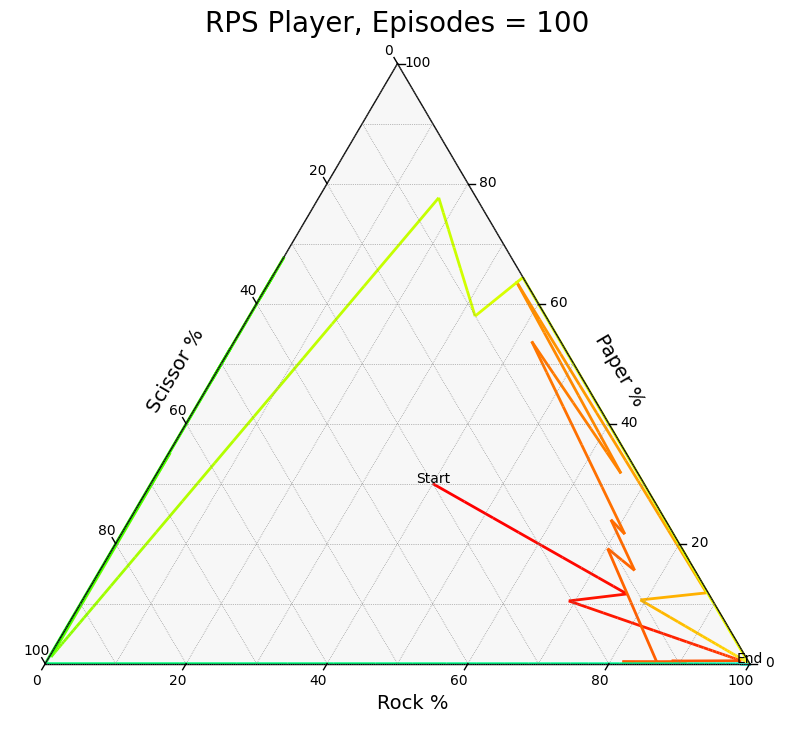

In [16]:
plot_ternary_diagram(fp_strategy)

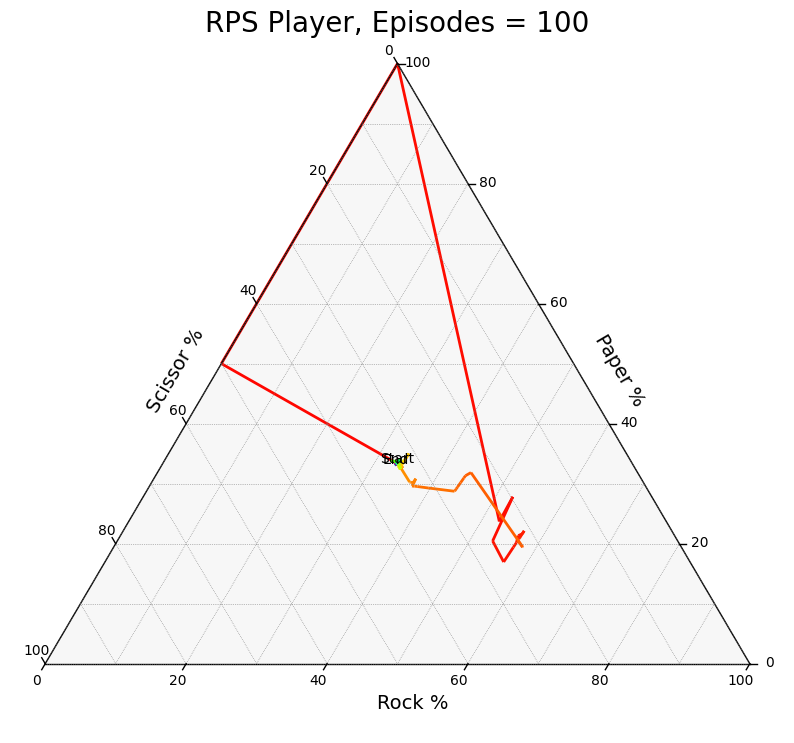

In [17]:
plot_ternary_diagram(rl_strategy)

# Matching Pennies

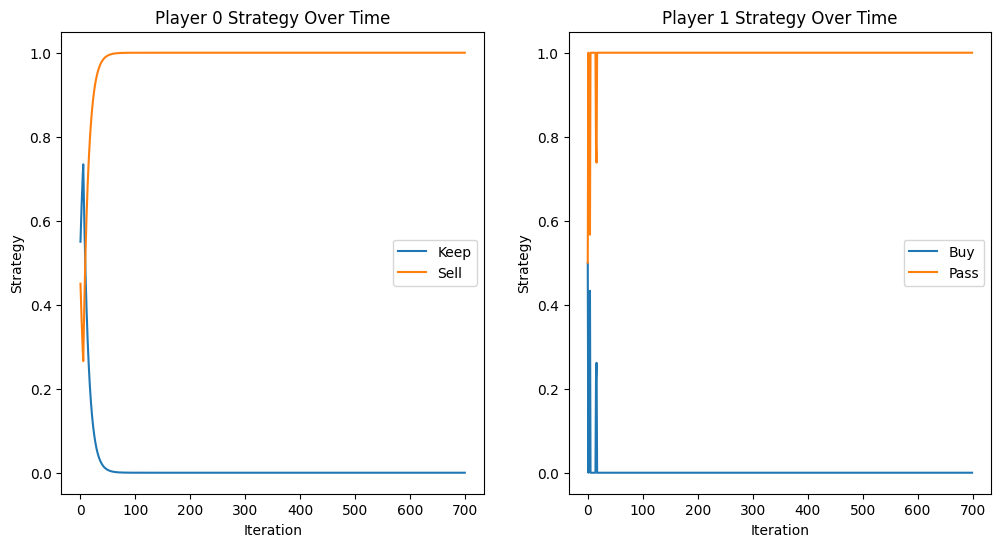

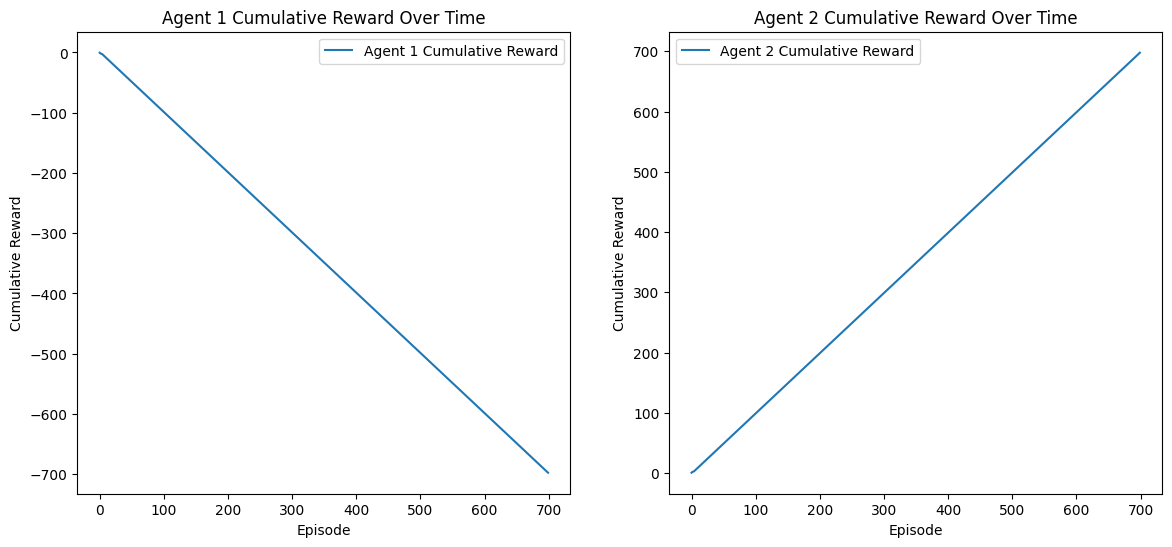

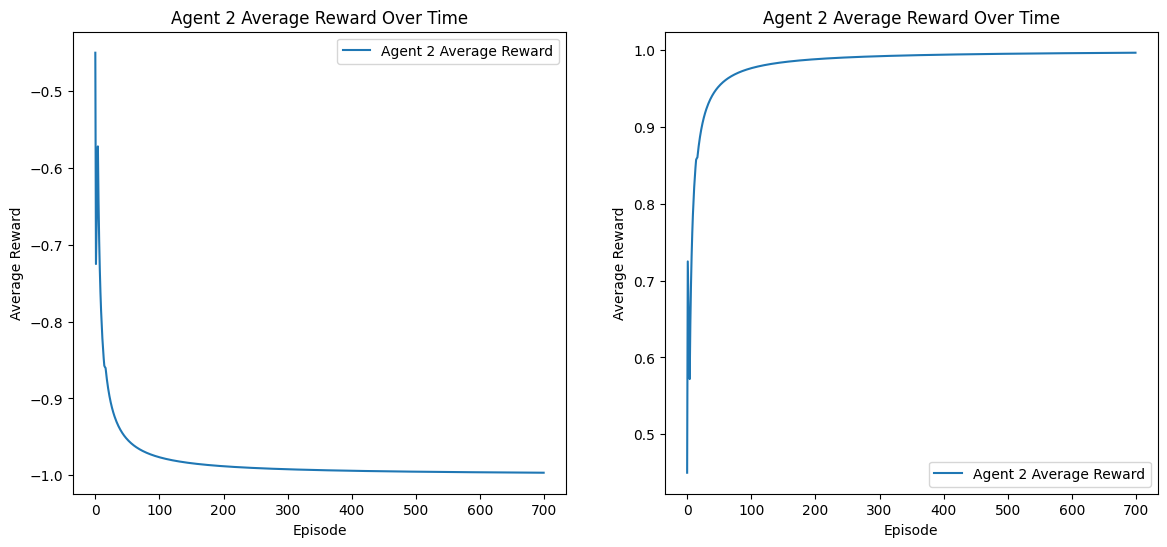

In [19]:
import numpy as np
import matplotlib.pyplot as plt

class MatrixGame:

    def __init__(self):

      self.reward_matrix = np.array([
                            [[1, -1], [-1, 1]],
                            [[-1, 1], [-1, 1]]])


    def step(self, action1, action2):
        return self.reward_matrix[action1][action2]

def calculate_utility(strategy_self, strategy_opponent, payoffsv):
    # Calculate the utility for self and opponent
    utility_self = strategy_self[0] * (strategy_opponent[0] * payoffs[0][0][0] + strategy_opponent[1] * payoffs[0][0][1]) + strategy_self[1] * (strategy_opponent[0] * payoffs[0][1][0] + strategy_opponent[1] * payoffs[0][1][1])
    utility_opponent = strategy_opponent[0] * (strategy_self[0] * payoffs[1][0][0] + strategy_self[1] * payoffs[1][1][0]) + strategy_opponent[1] * (strategy_self[0] * payoffs[1][0][1] + strategy_self[1] * payoffs[1][1][1])

    return utility_self, utility_opponent

def run_simulation(episodes, fp_agent, rl_agent, game):
    fp_strategy = []
    rl_strategy = []
    cumulative_rewards_history_agent1 = []
    cumulative_rewards_history_agent2 = []
    average_rewards_history_agent1 = []
    average_rewards_history_agent2 = []
    cumulative_reward_agent1 = 0
    cumulative_reward_agent2 = 0

    for episode in range(episodes):
        fp_action = fp_agent.act()
        rl_action = rl_agent.take_action()

        reward_fp, reward_rl = game.step(fp_action, rl_action)

        rl_agent.observe(action=rl_action, opponent=fp_action, reward=reward_rl)
        rl_agent.update_Q(rl_action, fp_action, reward_rl)
        rl_agent.update_P()
        rl_agent.update_V()

        fp_agent.update_strategy(rl_action)

        fp_strategy.append(fp_agent.avg_strategy)
        rl_strategy.append(rl_agent.P)

        u1,u2 = calculate_utility(fp_agent.avg_strategy,rl_agent.P,game.reward_matrix )
        # Update cumulative rewards
        cumulative_reward_agent1 += u1
        cumulative_reward_agent2 += u2

        # Store history for plotting
        cumulative_rewards_history_agent1.append(cumulative_reward_agent1)
        cumulative_rewards_history_agent2.append(cumulative_reward_agent2)

        average_rewards_history_agent1.append(cumulative_reward_agent1 / (episode + 1))
        average_rewards_history_agent2.append(cumulative_reward_agent2 / (episode + 1))


    return fp_strategy, rl_strategy, average_rewards_history_agent1, average_rewards_history_agent2, cumulative_rewards_history_agent1, cumulative_rewards_history_agent2


# Example Setup
actions = [0, 1]
game = MatrixGame()
fp_agent = FictitiousPlayAgent(actions, game.reward_matrix[0])  # Adjust initialization as necessary
rl_agent = QAgent(explor=0.3, learning_rate=0.6, gamma=0.9, player_id=1, actions=actions)  # Adjust initialization as necessary

fp_strategy, rl_strategy, average_rewards_history_agent1, average_rewards_history_agent2,  cumulative_rewards_history_agent1, cumulative_rewards_history_agent2 = run_simulation(episodes=700, fp_agent=fp_agent, rl_agent=rl_agent, game=game)


plt.figure(figsize=(12, 6))

# Plotting player 0's strategy
plt.subplot(1, 2, 1)
# Plotting strategies over time
# Example plot for player 0's strategy over time
plt.plot(fp_strategy)
plt.title('Player 0 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Keep', 'Sell'])


# Plotting player 0's strategy
plt.subplot(1, 2, 2)
# Plotting strategies over time
# Example plot for player 0's strategy over time
plt.plot(rl_strategy)
plt.title('Player 1 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Buy', 'Pass'])
plt.show()

# Plot cumulative rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards_history_agent1, label='Agent 1 Cumulative Reward')
plt.title('Agent 1 Cumulative Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_rewards_history_agent2, label='Agent 2 Cumulative Reward')
plt.title('Agent 2 Cumulative Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

# Plot cumulative rewards over time for both agents
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(average_rewards_history_agent1, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(average_rewards_history_agent2, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

# Selling Damaged Goods

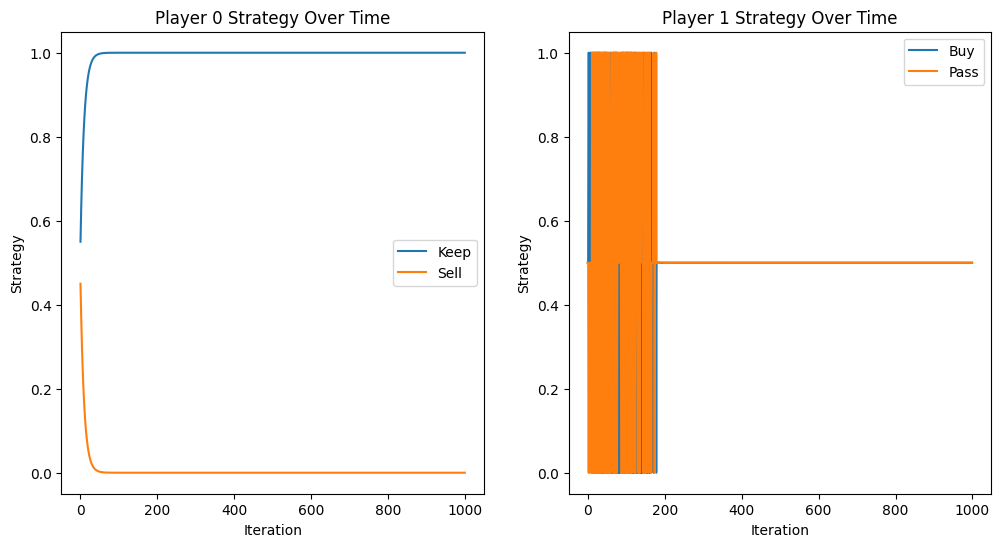

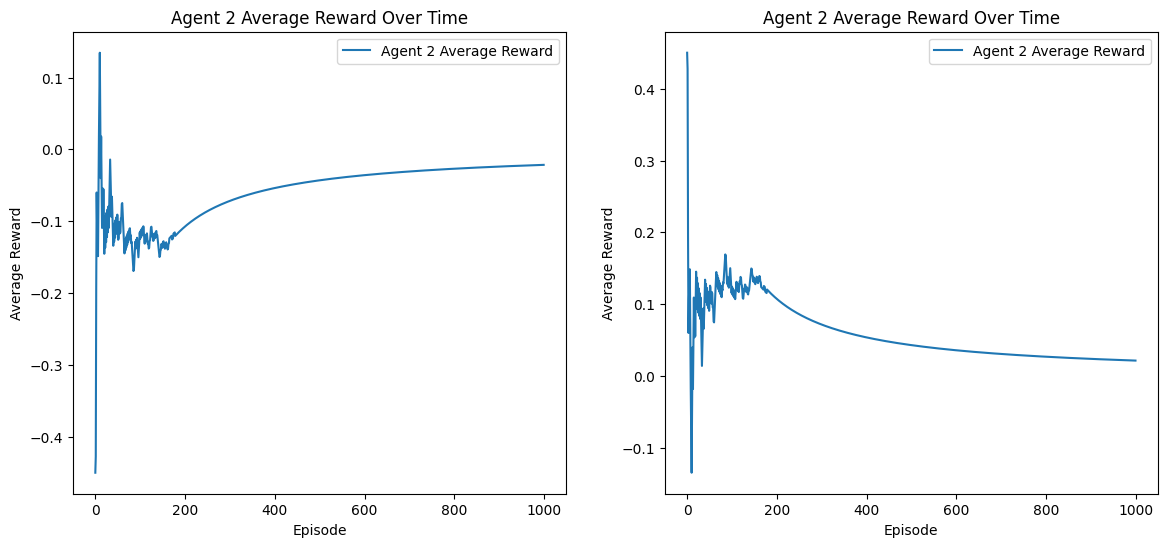

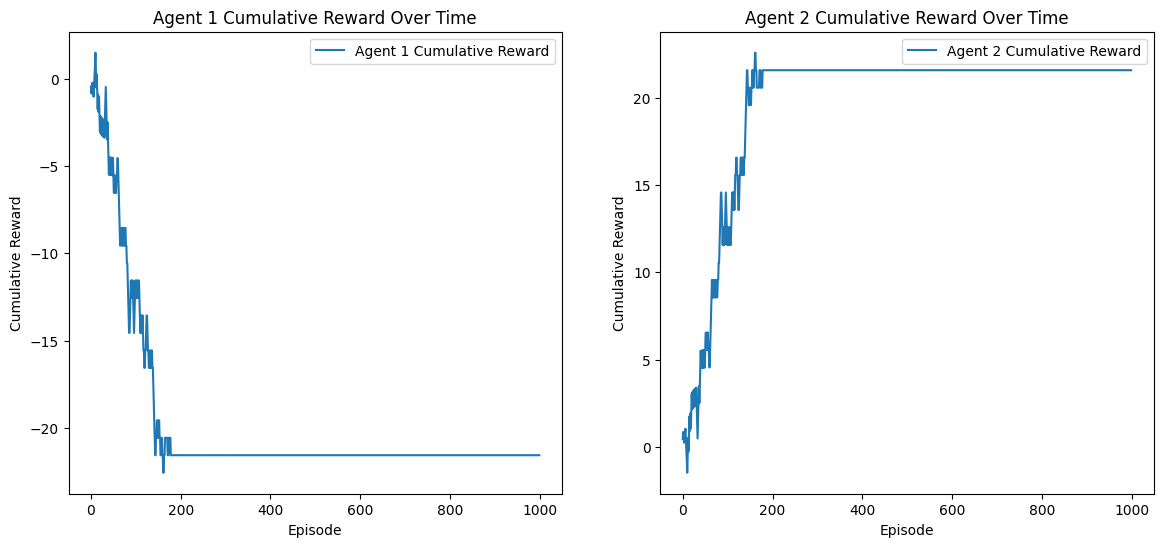

In [20]:
import numpy as np
import matplotlib.pyplot as plt


class MatrixGame:

    def __init__(self):

      self.reward_matrix = np.array([
                            [[1,-1], [-1, -1]], [[-1,1], [1, 1]]])


    def step(self, action1, action2):
        return self.reward_matrix[action1][action2]

def calculate_utility(strategy_self, strategy_opponent, payoffsv):
    # Calculate the utility for self and opponent

    utility_self = strategy_self[0] * (strategy_opponent[0] * payoffs[0][0][0] + strategy_opponent[1] * payoffs[0][0][1]) + strategy_self[1] * (strategy_opponent[0] * payoffs[0][1][0] + strategy_opponent[1] * payoffs[0][1][1])
    utility_opponent = strategy_opponent[0] * (strategy_self[0] * payoffs[1][0][0] + strategy_self[1] * payoffs[1][1][0]) + strategy_opponent[1] * (strategy_self[0] * payoffs[1][0][1] + strategy_self[1] * payoffs[1][1][1])

    return utility_self, utility_opponent

def run_simulation(episodes, fp_agent, rl_agent, game):
    fp_strategy = []
    rl_strategy = []
    cumulative_rewards_history_agent1 = []
    cumulative_rewards_history_agent2 = []
    average_rewards_history_agent1 = []
    average_rewards_history_agent2 = []
    cumulative_reward_agent1 = 0
    cumulative_reward_agent2 = 0

    for episode in range(episodes):
        fp_action = fp_agent.act()
        rl_action = rl_agent.take_action()

        reward_fp, reward_rl = game.step(fp_action, rl_action)

        rl_agent.observe(action=rl_action, opponent=fp_action, reward=reward_rl)
        rl_agent.update_Q(rl_action, fp_action, reward_rl)
        rl_agent.update_P()
        rl_agent.update_V()

        fp_agent.update_strategy(rl_action)

        fp_strategy.append(fp_agent.avg_strategy)
        rl_strategy.append(rl_agent.P)

        u1,u2 = calculate_utility(fp_agent.avg_strategy,rl_agent.P,game.reward_matrix )
        # Update cumulative rewards
        cumulative_reward_agent1 += u1
        cumulative_reward_agent2 += u2

        # Store history for plotting
        cumulative_rewards_history_agent1.append(cumulative_reward_agent1)
        cumulative_rewards_history_agent2.append(cumulative_reward_agent2)

        average_rewards_history_agent1.append(cumulative_reward_agent1 / (episode + 1))
        average_rewards_history_agent2.append(cumulative_reward_agent2 / (episode + 1))

    return fp_strategy, rl_strategy, average_rewards_history_agent1, average_rewards_history_agent2, cumulative_rewards_history_agent1, cumulative_rewards_history_agent2


# Example Setup
actions = [0, 1]  # Adjust based on your game's actions
game = MatrixGame()
fp_agent = FictitiousPlayAgent(actions, game.reward_matrix[0])  # Adjust initialization as necessary
rl_agent = QAgent(explor=0.3, learning_rate=0.6, gamma=0.9, player_id=2, actions=actions)  # Adjust initialization as necessary

fp_strategy, rl_strategy, average_rewards_history_agent1, average_rewards_history_agent2,  cumulative_rewards_history_agent1, cumulative_rewards_history_agent2 = run_simulation(episodes=1000, fp_agent=fp_agent, rl_agent=rl_agent, game=game)


plt.figure(figsize=(12, 6))

# Plotting player 0's strategy
plt.subplot(1, 2, 1)
# Plotting strategies over time
# Example plot for player 0's strategy over time
plt.plot(fp_strategy)
plt.title('Player 0 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Keep', 'Sell'])

# Plotting player 0's strategy
plt.subplot(1, 2, 2)
# Plotting strategies over time
# Example plot for player 0's strategy over time
plt.plot(rl_strategy)
plt.title('Player 1 Strategy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Strategy')
plt.legend(['Buy', 'Pass'])


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(average_rewards_history_agent1, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(average_rewards_history_agent2, label='Agent 2 Average Reward')
plt.title('Agent 2 Average Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()

# Plot cumulative rewards over time for both agents
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards_history_agent1, label='Agent 1 Cumulative Reward')
plt.title('Agent 1 Cumulative Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_rewards_history_agent2, label='Agent 2 Cumulative Reward')
plt.title('Agent 2 Cumulative Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.show()